# Decode against a preodor baseline period, within a trial type. Must have at least 5 trials of a specific trial type/outcome for animal to contribute to decoding for that particular trial type

In [1]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
# %%javascript
# var nb = IPython.notebook;
# var kernel = IPython.notebook.kernel;
# var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
# kernel.execute(command);

In [4]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_vs_baseline_dhpc'

In [5]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
#load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [6]:
import h5py

def do_decoding_combined_within(patterns, labels, n_loops=10, ncells=None, cellreg=False, n_steps=15, **args):
     
    scores = np.r_[[do_test_within(patterns, labels, **args) for i in range(n_loops)]]
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in patterns.keys()])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells = np.r_[[do_test_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, ncells, scores_ncells


from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def combine_train_test_patterns(patterns, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    patterns_t={}
    patterns_T={}
    labels_t={}
    labels_T={}
    not_run=[]
    for ani in patterns.keys():
        #print ani,np.shape(np.where(labels[ani]==classes[0]))[-1]
        if np.shape(np.where(labels[ani]==classes[0]))[-1]>=5:  #only include animal if it has x trials of specified trial type
            which_trains = []
            which_tests = []
            for l in classes:
                if l>=0:
                    wt = np.random.permutation(np.where(labels[ani]==l)[0])
                    if train_test_split<1:
                        wT = wt[:int(len(wt)*train_test_split)]
                        which_trains.append(wt[int(len(wt)*train_test_split):])
                        which_tests.append(wT)
                    else:
                        which_trains.append(wt)
            which_train[ani] = np.concatenate(which_trains)
            if train_test_split<1:
                which_test[ani] = np.concatenate(which_tests)
        else:
            not_run.append(ani)
            #print '(NO',ani,')',
    for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
        #patterns_t[ani] = patterns[ani].copy()
        #labels_t[ani] = labels[ani].copy()
        #print which_train.keys()
    #for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
    #    print ani
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = combine_patterns(patterns_t, labels_t, classes=classes)

        
    if train_test_split<1:
        for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
            #patterns_T[ani] = patterns[ani].copy()
            #labels_T[ani] = labels[ani].copy()
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
    
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0],not_run,which_cells)
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None,not_run,which_cells)

def do_test_within(patterns, labels, **args):
    x, y, xT, yT,not_run,which_cells = combine_train_test_patterns(patterns, labels, **args)
    decoder.fit(x, y)
    #print "Not run:",not_run
    return decoder.score(xT, yT)

def Not_Run(patterns, labels, **args):
    x, y, xT, yT,not_run,which_cells = combine_train_test_patterns(patterns, labels, **args)
    return not_run,sum(which_cells)
        
def load_cellreg(animal, filename='pre_vs_post.mat', keys=['pre', 'post']):
    with h5py.File('../%s/data/%s'%(animal, filename), 'r') as f:
        g = np.r_[f['cell_registered_struct']['cell_to_index_map']]
        cellreg_dict = {k:g[i][np.where(np.prod([gg>0 for gg in g], 0))[0]].astype(int)-1
                        for i, k in enumerate(keys)}
    return cellreg_dict

def combine_patterns(patterns, labels, n_patterns=100, classes=[0, 1], labels_mask=None):
    labels_comb = np.r_[list(classes)*n_patterns]
    patterns_comb_train = []
    for i in xrange(n_patterns):
        for odor in classes:
            try:
                p = np.concatenate([patterns[ani][np.random.choice([w for w in np.where(labels[ani]==odor)[0]])]
                                for ani in patterns.keys()])
                patterns_comb_train.append(p)
            except:
                #print "no %s labels"%odor,
                continue
    return np.r_[patterns_comb_train], labels_comb

In [7]:
decoder = SVC(kernel='linear', decision_function_shape='ovo')

In [8]:
from matplotlib.lines import Line2D
def add_significance(ax, array1, array2, x1, x2, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001)):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
    ax.add_line(line)
    ax.text(np.mean([x1, x2]), y+1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4)
    return sig_value, p

In [9]:
def sig_vs_chance(ax, array1, chance, x1, y1, loops=15, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),colors='k'):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        p = sig_func(subtracted)[-1]
        sig_value = sig_func(subtracted)[0]
    elif sig_func is ttest:
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        p = sig_func(array1,chance)[-1]
        sig_value = sig_func(array1,chance)[0]
    ax.text(x1, y1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4, color=colors)
    return sig_value, p

In [10]:
expo_animals = 'dhpc37', 'dhpc39', 'dhpc40', 'dNAc3', 'dNAc4'
pre_animals =  'dhpc37', 'dhpc39', 'dhpc40', 'dNAc3', 'dNAc4'
post_animals = 'dhpc37', 'dhpc39', 'dhpc40', 'dNAc3', 'dNAc4'
post_hiatus_animals = 'dhpc37', 'dhpc39', 'dhpc40', 'dNAc3', 'dNAc4'

In [11]:
delta_t05s = 0.5
t_start05s = -5.5 
t_stop05s = 10.5

delta_t1s = 1
t_start1s = -5 
t_stop1s  = 11 

delta_t15s = 1
t_start15s = -5.5 
t_stop15s = 10.5  

delta_t2s = 2
t_start2s = -4
t_stop2s  = 10

In [12]:
sessions = 'expo','pre','post','post_hiatus'
bins = ['05s','1s','15s','2s']
bin_ranges=[]
for tb in bins:
    if tb == '05s':
        div=0.5
    elif tb=='15s':
        div=1.0
    else:
        div=tb[:-1]
            #print range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
    #for t in range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div)))):
    bin_ranges.append(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
print bin_ranges

[32, 16, 16, 7]


In [13]:
for tb in bins:
    for sess in sessions:
        try:
            exec("patterns_%s_%s = dict(zip(%s_animals, [ut.load_variable('patterns_evs_%s_%s',\
                                                               '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                      for ani in %s_animals]))"%(tb,sess,sess,tb,sess,sess))
            exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels_%s',\
                                                             '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                      for ani in %s_animals]))"%(sess,sess,sess,sess))
        except:
            print 'nope %s %s'%(tb,sess)

In [14]:
for sess in sessions:
    for tb,i in zip(bins,range(len(bins))):
        for t in range(bin_ranges[i]):
            exec('patterns_%s_%s_%s = {}'%(tb,sess,t))
            for ani in eval('%s_animals'%sess):
                try:
                    #print sess, tb, ani,
                    exec("patterns_%s_%s_%s['%s'] = patterns_%s_%s['%s'][%s]"%(tb,sess,t,ani,tb,sess,ani,t))
                except:
                    print 'NOPE',sess, tb, ani
                    continue

### need to take data from a single trial type and duplicate it, assigning it a new label/class. Then use the baseline time bin of the dataset with this new label and decode against all time bins from original dataset

In [15]:
#make a new label array, assigning new labels for each trial type
relabel_baselines = {1:10,2:20,3:30,4:40}

for sess in sessions:
    for tb in bins:
        try:
            exec("labels_baselines_%s = {}"%sess)
            for ani in eval("%s_animals"%sess):
                exec("labels_baselines_%s[ani] = np.r_[[relabel_baselines[l] for l in labels_%s[ani]]]"%(sess,sess))
        except:
            print 'nope %s %s'%(sess,tb)

In [16]:
#concatenate new label array to original
for sess in sessions:
    for tb in bins:
        try:
            exec("labels_%s_w_baselines = {}"%sess)
            for ani in eval("labels_%s.keys()"%sess):
                exec("labels_%s_w_baselines[ani] = np.concatenate((labels_%s[ani],labels_baselines_%s[ani]))"%(sess,sess,sess))
        except:
            print 'nope %s %s'%(sess,tb)

In [17]:
# concatenate patterns from one time bin with itself
bases = [4,1,1,0] #time bins for each tb delta to use for baseline (start at 3.5s, 4s, 4.5s, 4s)
for tb,ind,base in zip(bins,range(len(bins)),bases):
    for sess in sessions:
        for t in range(bin_ranges[ind]):
            try:
                exec('patterns_%s_%s_%s_w_baselines = {}'%(tb,sess,t))
                for ani in eval('patterns_%s_%s_%s.keys()'%(tb,sess,t)):
                    exec("patterns_%s_%s_%s_w_baselines[ani] = np.concatenate((patterns_%s_%s_%s[ani],\
                    patterns_%s_%s_%s[ani]))"%(tb,sess,t,tb,sess,t,tb,sess,base))
            except:
                    print 'NOPE', sess, ani, tb

#### now decode using both labels from a single trial type, reserving one label for the baseline time bin, and the other label for all time bins

In [18]:
%%time
#get train and test subsamples for each timebin, for each session
n_loops=15
classes = [1,10],[2,20],[3,30],[4,40]
comparison_labels='CS1','CS2','CS3','CS4'

for cl,comp_la in zip(classes,comparison_labels):
    for tb,i in zip(bins,range(len(bins))):
        for t in range(bin_ranges[i]): # number of time bins
            exec('baseline_scores_%s_%s_%s = {}'%(tb,t,comp_la))
            for sess in sessions:
                print sess,t,comp_la,
                try:
                    eval("baseline_scores_%s_%s_%s"%(tb,t,comp_la))[sess] = np.r_[[do_test_within(eval("patterns_%s_%s_%s_w_baselines"%(tb,sess,t)),
                        eval("labels_%s_w_baselines"%sess),classes=cl, n_cells=None, relabel=None) for i in range(n_loops)]]
                except:
                    print 'NOPE',
    for sess in sessions:
        try:
            exec("not_run,total_cells_%s = Not_Run(patterns_%s_%s_%s_w_baselines,labels_%s_w_baselines,classes=cl, n_cells=None,\
                  relabel=None)"%(sess,tb,sess,t,sess))
            print "\n\nNOT INCLUDED IN ANALYSIS (too few trials):",not_run
            print "total cells =",eval("total_cells_%s"%(sess))
        except:
            print "NO ANIMALS MET CRITERIA (all had too few trials)"
            exec("total_cells_%s=0"%(sess))
    
        #exec("total_%s_vs_%s_trials_post = 0"%(comp[0],comp[1]))
        for key in labels_post_w_baselines.keys():
            v0=0
            for val in labels_post_w_baselines[key]:
                if val == cl[0]:
                    v0 += 1
            exec("vals_%s =v0"%key)
            #print "animal %s="%key,eval("vals_%s"%key),"trials"
        sum_vals=0
        for key in labels_post_w_baselines.keys():
            if eval("vals_%s"%key)>=5:
                sum_vals = sum_vals + eval("vals_%s"%key)
        exec("total_%s_trials_post = sum_vals"%(comp_la))
        print "total_%s_trials_post ="%(comp_la),eval("total_%s_trials_post"%(comp_la)),"\n"

expo 0 CS1 pre 0 CS1 post 0 CS1 post_hiatus 0 CS1 expo 1 CS1 pre 1 CS1 post 1 CS1 post_hiatus 1 CS1 expo 2 CS1 pre 2 CS1 post 2 CS1 post_hiatus 2 CS1 expo 3 CS1 pre 3 CS1 post 3 CS1 post_hiatus 3 CS1 expo 4 CS1 pre 4 CS1 post 4 CS1 post_hiatus 4 CS1 expo 5 CS1 pre 5 CS1 post 5 CS1 post_hiatus 5 CS1 expo 6 CS1 pre 6 CS1 post 6 CS1 post_hiatus 6 CS1 expo 7 CS1 pre 7 CS1 post 7 CS1 post_hiatus 7 CS1 expo 8 CS1 pre 8 CS1 post 8 CS1 post_hiatus 8 CS1 expo 9 CS1 pre 9 CS1 post 9 CS1 post_hiatus 9 CS1 expo 10 CS1 pre 10 CS1 post 10 CS1 post_hiatus 10 CS1 expo 11 CS1 pre 11 CS1 post 11 CS1 post_hiatus 11 CS1 expo 12 CS1 pre 12 CS1 post 12 CS1 post_hiatus 12 CS1 expo 13 CS1 pre 13 CS1 post 13 CS1 post_hiatus 13 CS1 expo 14 CS1 pre 14 CS1 post 14 CS1 post_hiatus 14 CS1 expo 15 CS1 pre 15 CS1 post 15 CS1 post_hiatus 15 CS1 expo 16 CS1 pre 16 CS1 post 16 CS1 post_hiatus 16 CS1 expo 17 CS1 pre 17 CS1 post 17 CS1 post_hiatus 17 CS1 expo 18 CS1 pre 18 CS1 post 18 CS1 post_hiatus 18 CS1 expo 19 CS1 pr

In [65]:
for sess in sessions:
        try:
            exec("not_run,total_cells_%s = Not_Run(patterns_%s_%s_%s_w_baselines,labels_%s_w_baselines,classes=cl, n_cells=None,\
                  relabel=None)"%(sess,tb,sess,t,sess))
            print "total cells %s="%sess,eval("total_cells_%s"%(sess))
        except:
            print "NO ANIMALS MET CRITERIA (all had too few trials)"
            exec("total_cells_%s=0"%(sess))

total cells expo= 1698
total cells pre= 1455
total cells post= 1264
total cells post_hiatus= 1396


In [19]:
dark_co = ('forestgreen','darkcyan','firebrick')

In [20]:
bin_ranges

[32, 16, 16, 7]

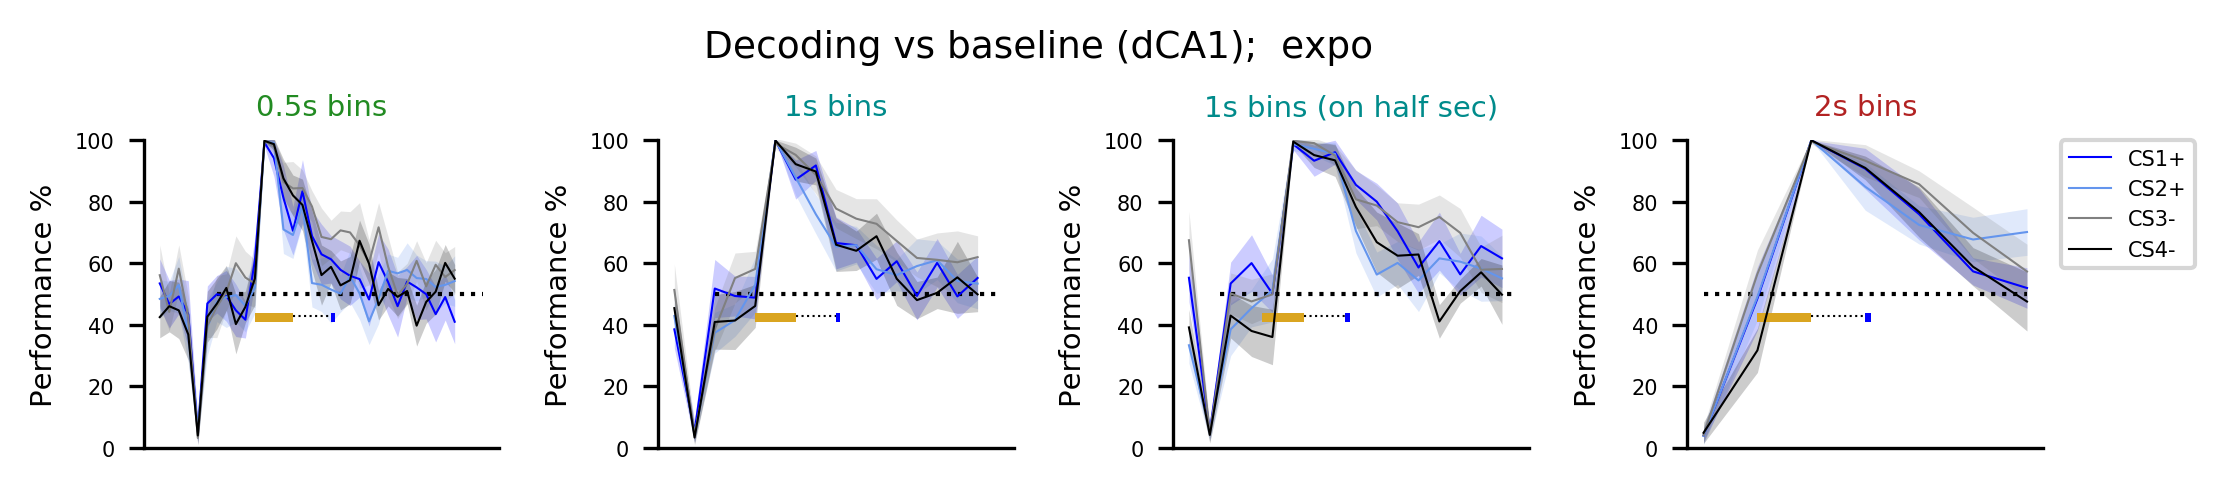

In [67]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))
session='expo'
for comp,c,la in zip(['CS1','CS2','CS3','CS4'],['b','cornflowerblue','grey','k'],['CS1+','CS2+','CS3-','CS4-']):
    for r,tb,sub in zip(range(4),bins,[10,4,3.5,1]):
        try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("baseline_scores_%s_%s_%s[session]"%(tb,t,comp)))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_%s_%s_%s[session]"%(tb,t,comp)))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("baseline_scores_%s_%s_%s[session]"%(tb,t,comp)))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        except:
            continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-4*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins', color=dark_co[0])
ax[1].set_title('1s bins', color = dark_co[1])
ax[2].set_title('1s bins (on half sec)', color = dark_co[1])
ax[3].set_title('2s bins', color = dark_co[2])
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (dCA1);  %s"%session, fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_%s.jpg'%(NOTEBOOK_NAME,session))

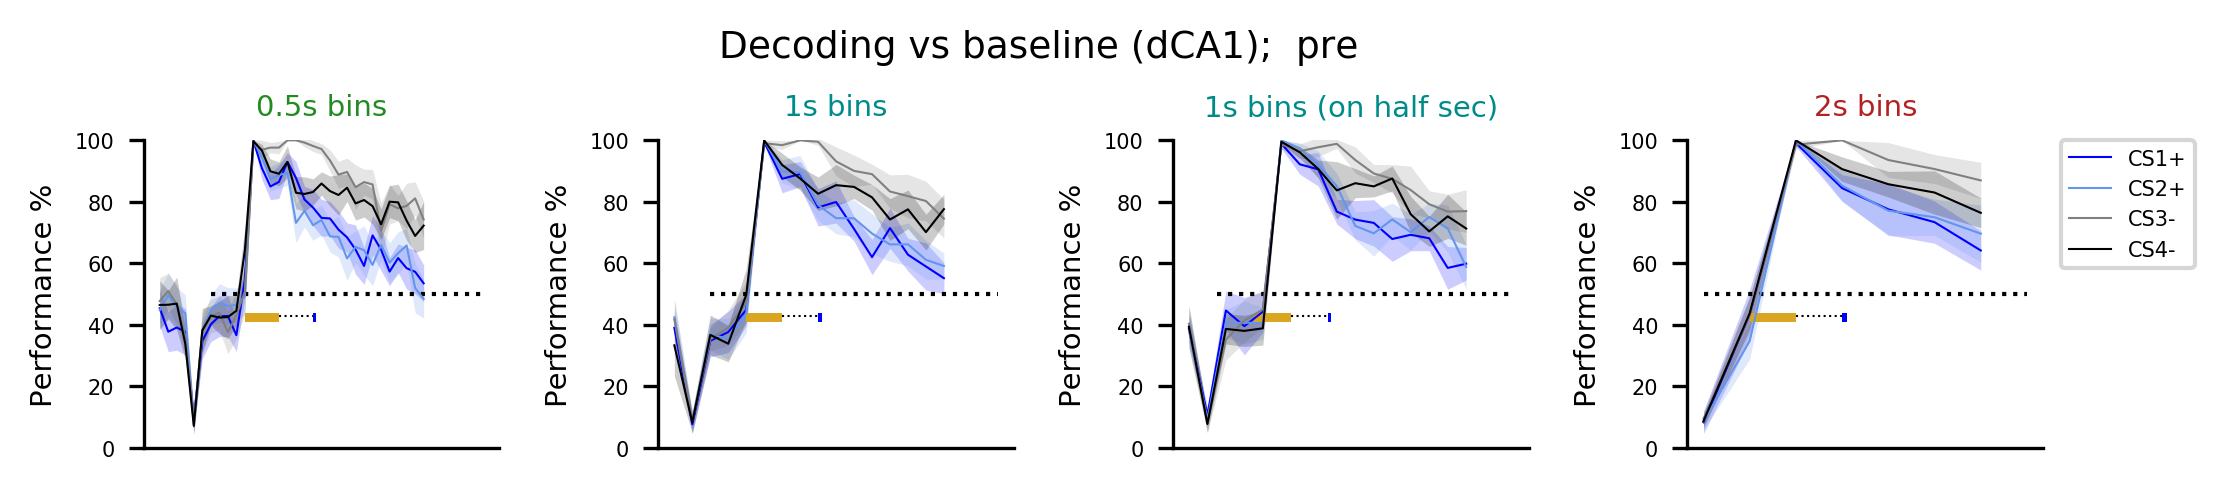

In [47]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))
session='pre'
for comp,c,la in zip(['CS1','CS2','CS3','CS4'],['b','cornflowerblue','grey','k'],['CS1+','CS2+','CS3-','CS4-']):
    for r,tb,sub in zip(range(4),bins,[10,4,3.5,1]):
        try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("baseline_scores_%s_%s_%s[session]"%(tb,t,comp)))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_%s_%s_%s[session]"%(tb,t,comp)))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("baseline_scores_%s_%s_%s[session]"%(tb,t,comp)))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        except:
            continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins', color=dark_co[0])
ax[1].set_title('1s bins', color = dark_co[1])
ax[2].set_title('1s bins (on half sec)', color = dark_co[1])
ax[3].set_title('2s bins', color = dark_co[2])
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (dCA1);  %s"%session, fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_%s.jpg'%(NOTEBOOK_NAME,session))

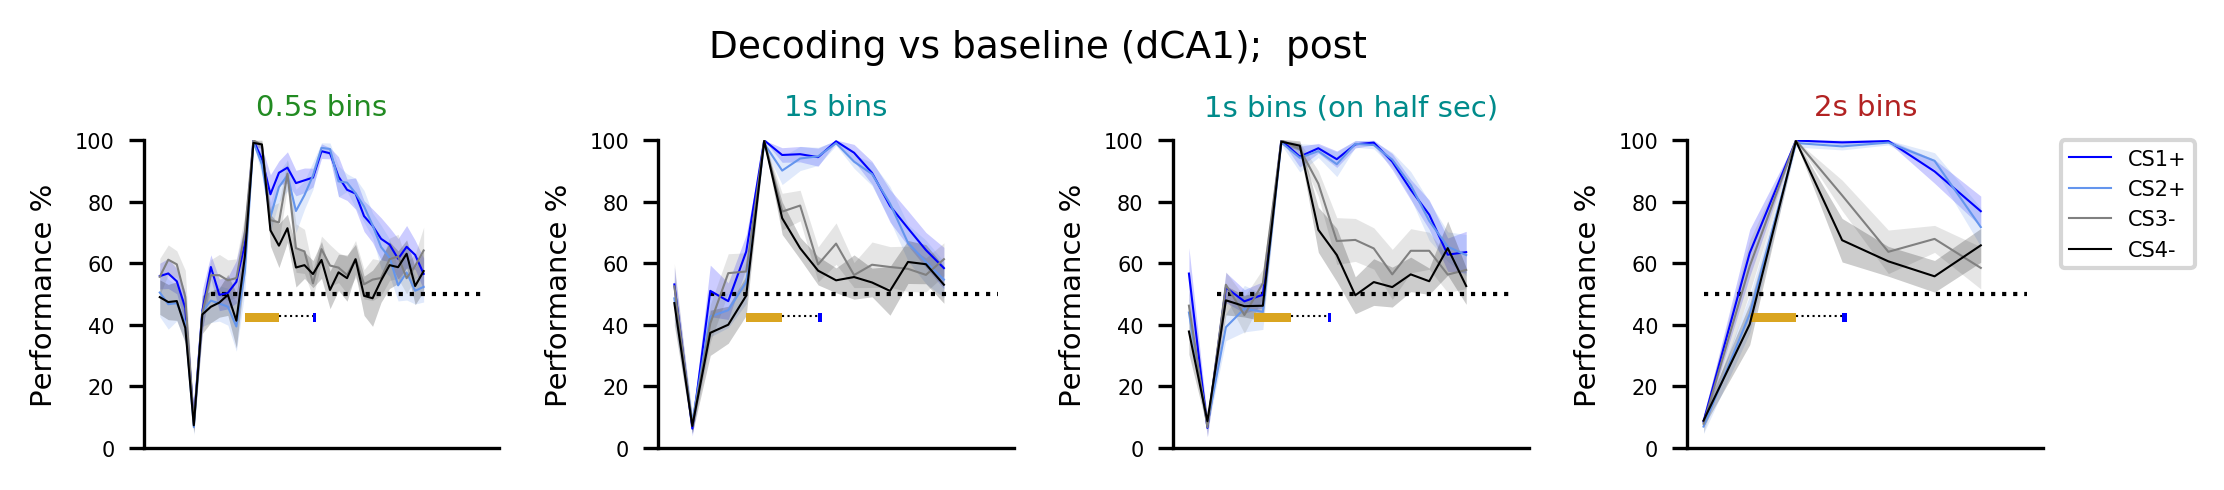

In [48]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))
session='post'
for comp,c,la in zip(['CS1','CS2','CS3','CS4'],['b','cornflowerblue','grey','k'],['CS1+','CS2+','CS3-','CS4-']):
    for r,tb,sub in zip(range(4),bins,[10,4,3.5,1]):
        try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("baseline_scores_%s_%s_%s[session]"%(tb,t,comp)))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_%s_%s_%s[session]"%(tb,t,comp)))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("baseline_scores_%s_%s_%s[session]"%(tb,t,comp)))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        except:
            continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins', color=dark_co[0])
ax[1].set_title('1s bins', color = dark_co[1])
ax[2].set_title('1s bins (on half sec)', color = dark_co[1])
ax[3].set_title('2s bins', color = dark_co[2])
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (dCA1);  %s"%session, fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_%s.jpg'%(NOTEBOOK_NAME,session))

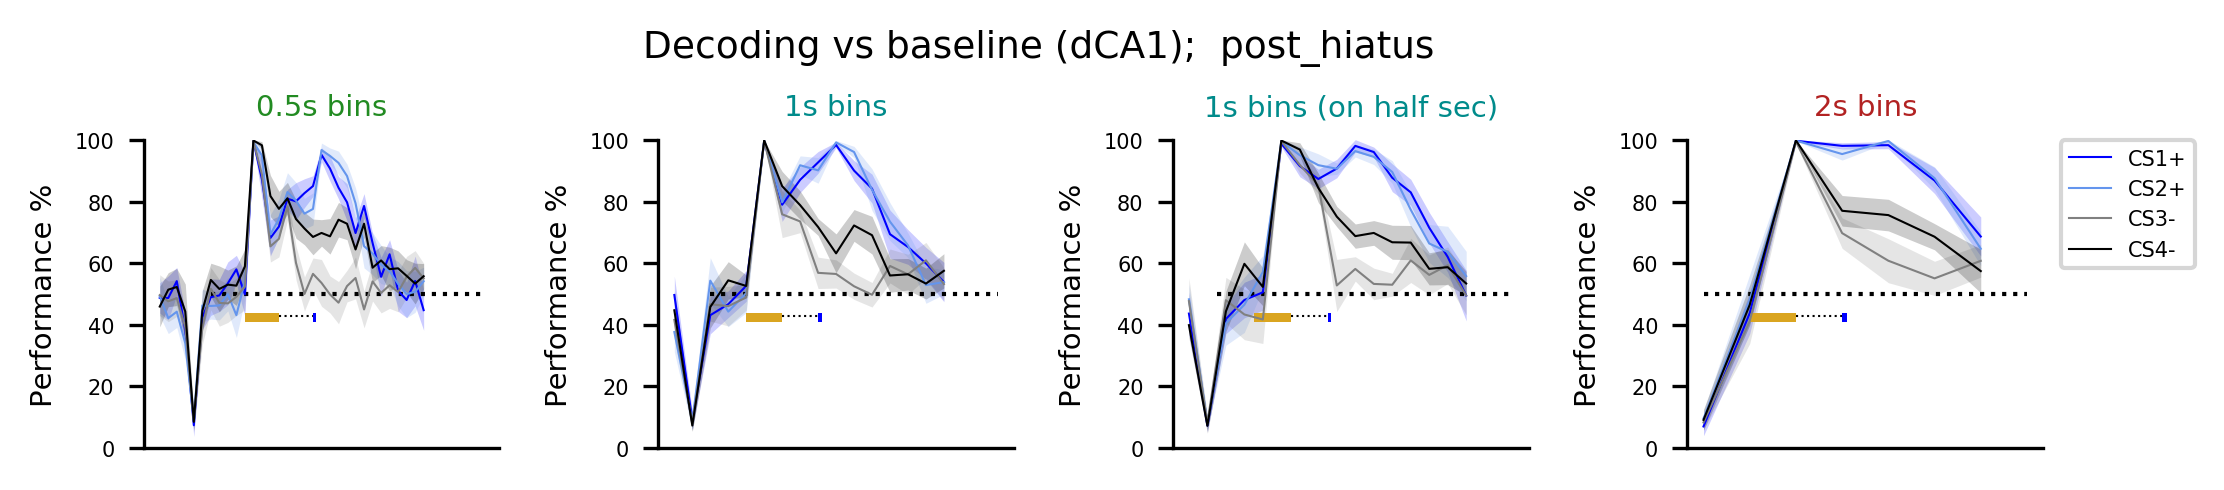

In [49]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))
session='post_hiatus'
for comp,c,la in zip(['CS1','CS2','CS3','CS4'],['b','cornflowerblue','grey','k'],['CS1+','CS2+','CS3-','CS4-']):
    for r,tb,sub in zip(range(4),bins,[10,4,3.5,1]):
        try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("baseline_scores_%s_%s_%s[session]"%(tb,t,comp)))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_%s_%s_%s[session]"%(tb,t,comp)))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("baseline_scores_%s_%s_%s[session]"%(tb,t,comp)))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        except:
            continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins', color=dark_co[0])
ax[1].set_title('1s bins', color = dark_co[1])
ax[2].set_title('1s bins (on half sec)', color = dark_co[1])
ax[3].set_title('2s bins', color = dark_co[2])
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (dCA1);  %s"%session, fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_%s.jpg'%(NOTEBOOK_NAME,session))

# now decode each animal individually

In [25]:
%%time
## use this from the decoding_around_onset nb (for a single animal) as a guide
from sklearn.svm import LinearSVC
decodor = LinearSVC()
from sklearn.model_selection import cross_val_score, LeaveOneOut

comparisons = [1,10],[2,20],[3,30],[4,40]
comparison_labels='CS1','CS2','CS3','CS4'
for tb,i in zip(bins,range(len(bins))):
    for t in range(bin_ranges[i]): # number of time bins
        for sess in sessions:
            for compare,comp_lab in zip(comparisons, comparison_labels):
                exec("individ_scores_%s_%s_%s_%s = {}"%(comp_lab,tb,sess,t))
                for ani in eval("patterns_%s_%s_%s_w_baselines.keys()"%(tb,sess,t)):
                    #try:
                        if np.shape(np.where(eval("labels_%s_w_baselines[ani]"%sess)==compare[0]))[-1]>=5:
                            eval("individ_scores_%s_%s_%s_%s"%(comp_lab,tb,sess,t))[ani]=[]
                            exec("which_trials = (labels_%s_w_baselines[ani]==compare[0], labels_%s_w_baselines[ani]==compare[1])"%(sess,sess)) # make 2 arrays
                            which_trials = which_trials[0]+which_trials[1] #add arrays
                            eval("individ_scores_%s_%s_%s_%s"%(comp_lab,tb,sess,t))[ani] = np.r_[[(cross_val_score(decodor,
                              eval("patterns_%s_%s_%s_w_baselines[ani]"%(tb,sess,t))[which_trials], eval("labels_%s_w_baselines[ani]"%sess)[which_trials],
                                 cv=LeaveOneOut()))]]
                            #print '%s_%s_%s_%s_%s Done'%(comp_lab,tb,sess,t,ani),
                        else:
                            print '%s_%s_%s_%s_%s NOPE'%(comp_lab,tb,sess,t,ani),
        print '%s bin %s done;'%(tb,t),

05s bin 0 done 05s bin 1 done 05s bin 2 done 05s bin 3 done 05s bin 4 done 05s bin 5 done 05s bin 6 done 05s bin 7 done 05s bin 8 done 05s bin 9 done 05s bin 10 done 05s bin 11 done 05s bin 12 done 05s bin 13 done 05s bin 14 done 05s bin 15 done 05s bin 16 done 05s bin 17 done 05s bin 18 done 05s bin 19 done 05s bin 20 done 05s bin 21 done 05s bin 22 done 05s bin 23 done 05s bin 24 done 05s bin 25 done 05s bin 26 done 05s bin 27 done 05s bin 28 done 05s bin 29 done 05s bin 30 done 05s bin 31 done 1s bin 0 done 1s bin 1 done 1s bin 2 done 1s bin 3 done 1s bin 4 done 1s bin 5 done 1s bin 6 done 1s bin 7 done 1s bin 8 done 1s bin 9 done 1s bin 10 done 1s bin 11 done 1s bin 12 done 1s bin 13 done 1s bin 14 done 1s bin 15 done 15s bin 0 done 15s bin 1 done 15s bin 2 done 15s bin 3 done 15s bin 4 done 15s bin 5 done 15s bin 6 done 15s bin 7 done 15s bin 8 done 15s bin 9 done 15s bin 10 done 15s bin 11 done 15s bin 12 done 15s bin 13 done 15s bin 14 done 15s bin 15 done 2s bin 0 done 2s bin 1

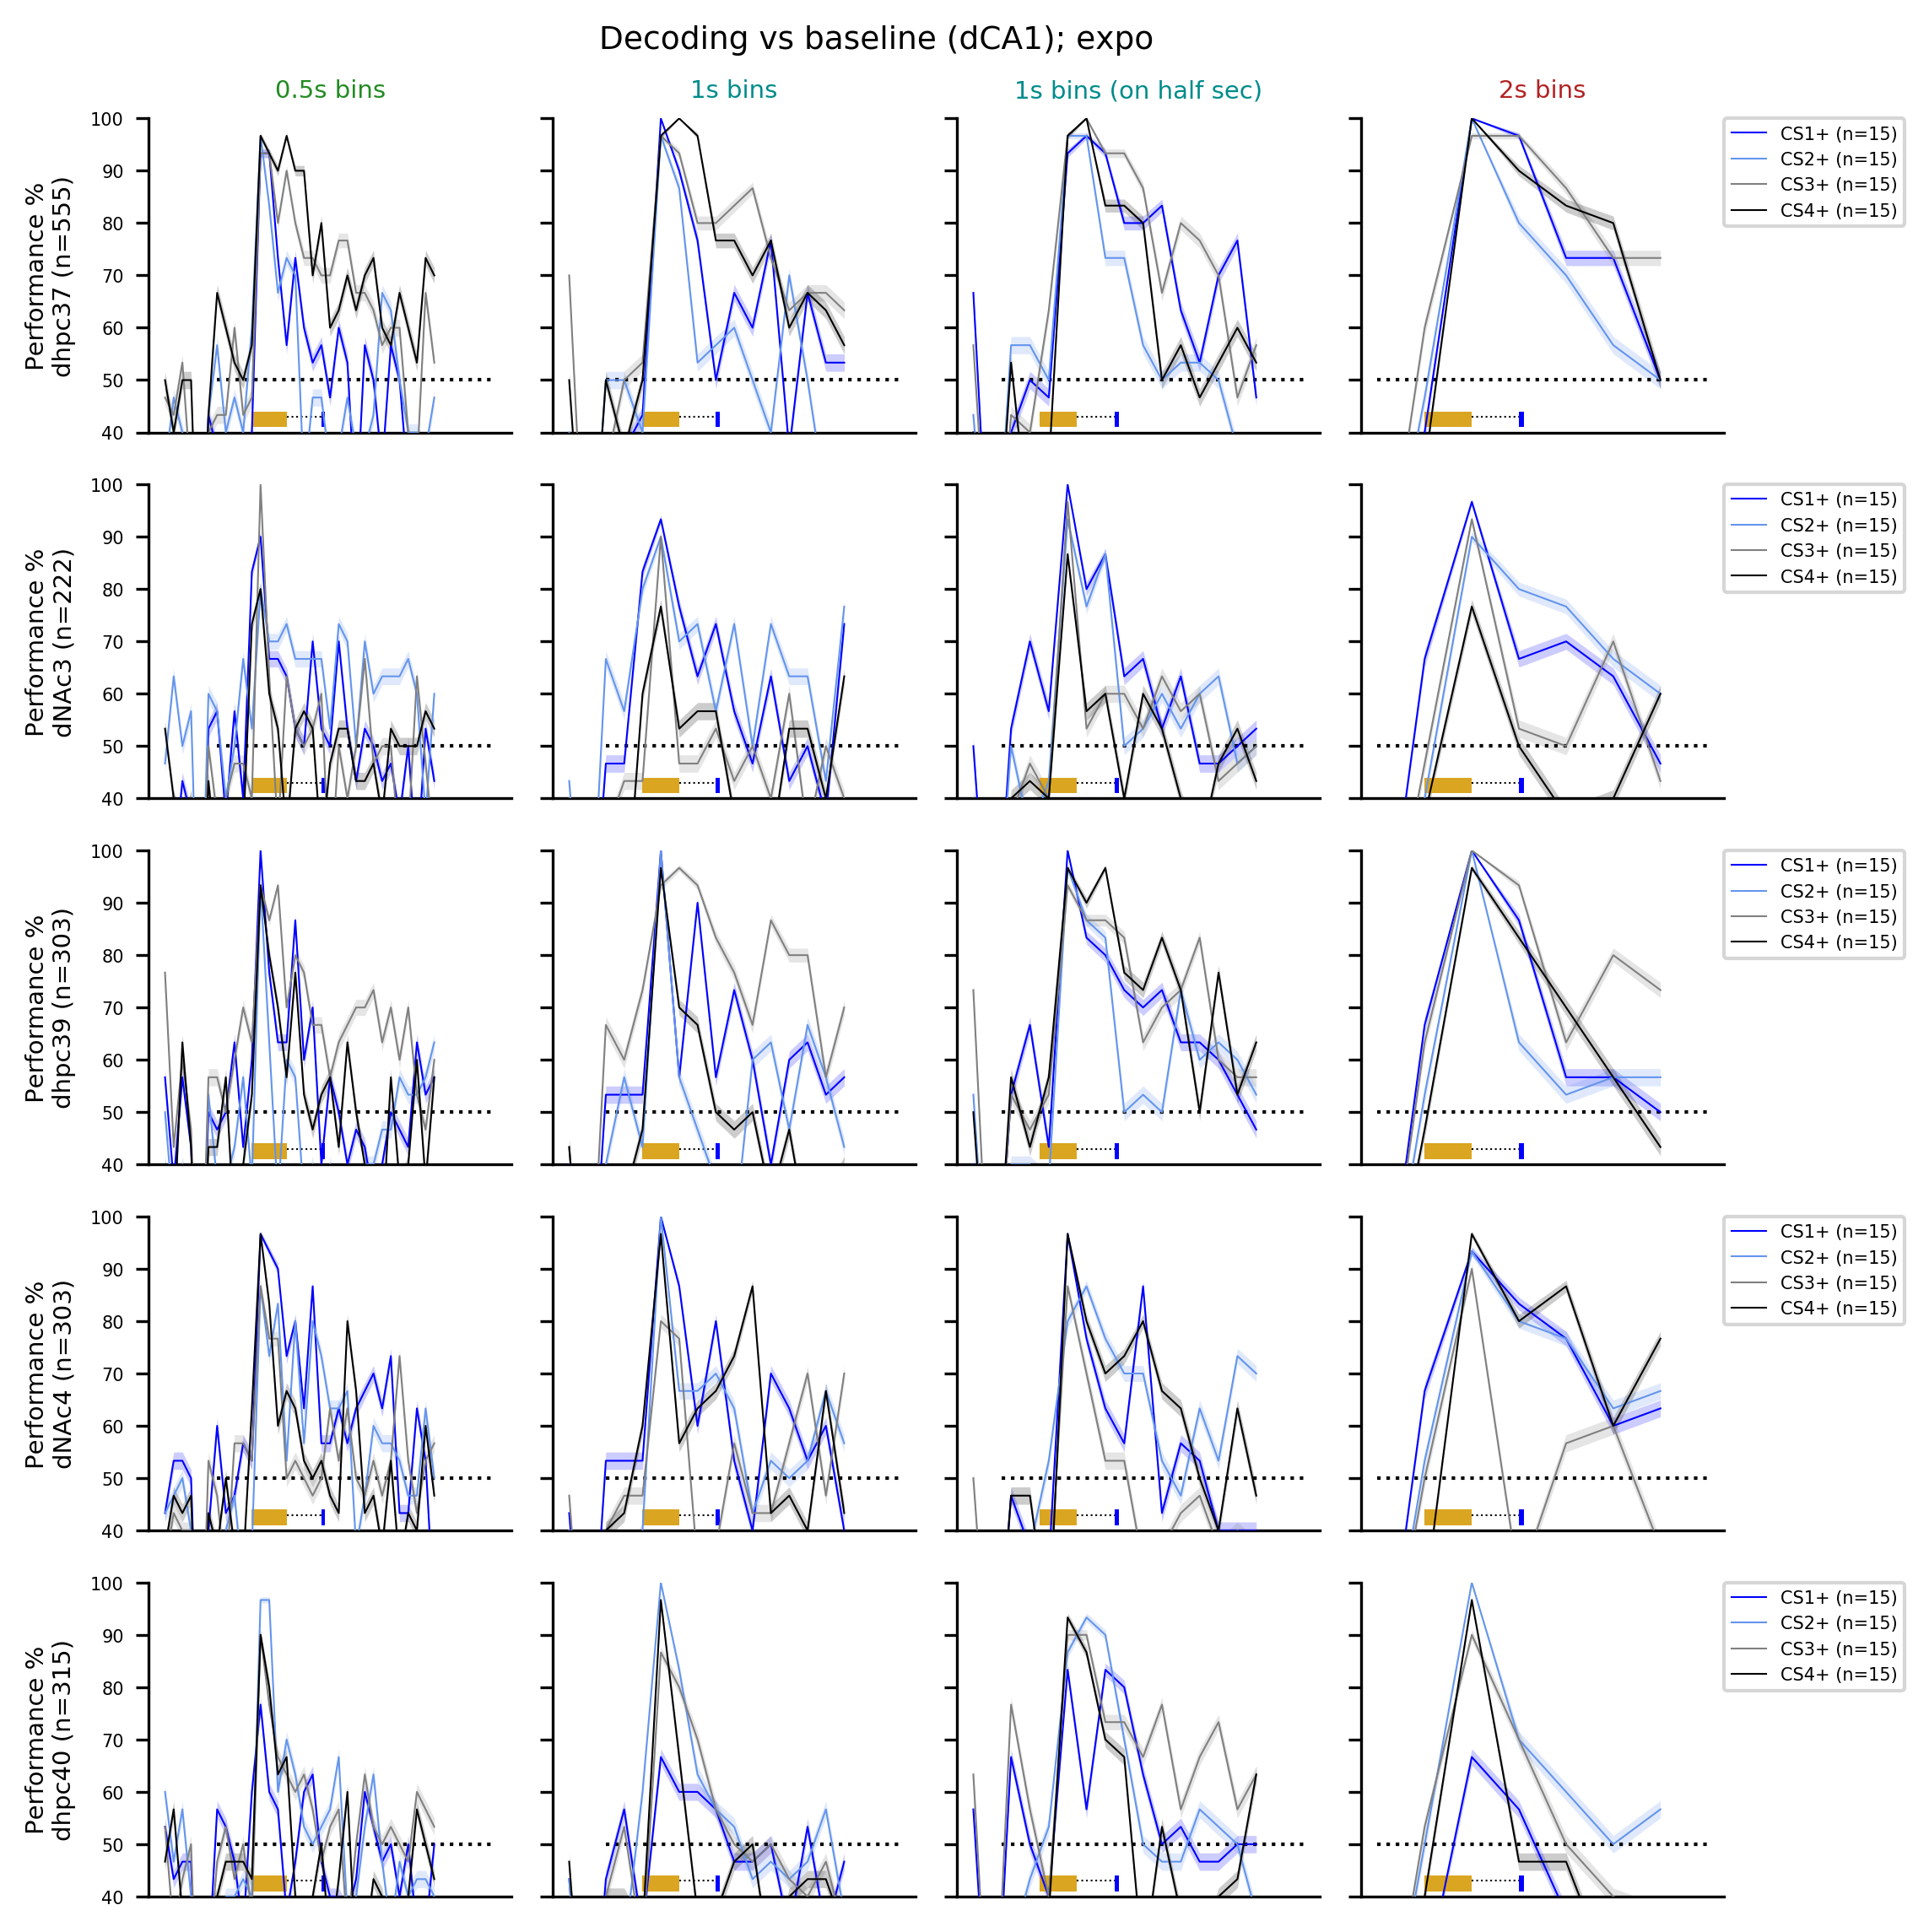

In [50]:
ses = 'expo'
fig, ax = pl.subplots(len(eval("labels_%s.keys()"%ses)),4, figsize=(7, 1.5*len(eval("labels_%s.keys()"%ses))),sharey=True)

for r,tb,sub in zip(range(4),bins,[10,4,3.5,1]):
    for y,key in zip(range(len(eval("labels_%s.keys()"%ses))),eval("labels_%s.keys()"%ses)):
        for comp,c,la in zip(['CS1','CS2','CS3','CS4'],['b','cornflowerblue','grey','k'],
                     ['CS1+ (n='+str(np.sum(eval("labels_%s[key]==1"%ses)))+")",
                      'CS2+ (n='+str(np.sum(eval("labels_%s[key]==2"%ses)))+")",
                      'CS3+ (n='+str(np.sum(eval("labels_%s[key]==3"%ses)))+")",
                      'CS4+ (n='+str(np.sum(eval("labels_%s[key]==4"%ses)))+")"]):
            try:
                ax[y][r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("individ_scores_%s_%s_%s_%s[key]"%(comp,tb,ses,t,)))*100) for t in range(bin_ranges[r])],
                           color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
                m = np.array([(np.mean(eval("individ_scores_%s_%s_%s_%s[key]"%(comp,tb,ses,t)))*100) for t in range(bin_ranges[r])])
                #s = np.array([np.std(eval("individ_scores_%s_%s_%s_%s['c18m9']"%(comp,tb,ses,t,)))*100 for t in range(bin_ranges[r])])
                SEM = np.array([(np.std(eval("individ_scores_%s_%s_%s_%s[key]"%(comp,tb,ses,t)))/(eval("individ_scores_%s_%s_%s_%s[key]"%(comp,tb,ses,t)).shape[1]))*100 for t in range(bin_ranges[r])])
                ax[y][r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-SEM,m+SEM,alpha=0.2,color=c,linewidth=0)
                ax[y][3].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
            except:
                continue
for x,tick in zip(range(4),[2,1,1,.5]):
    for y,key in zip(range(len(eval("labels_%s.keys()"%ses))),eval("labels_%s.keys()"%ses)):
        ax[y][x].set_ylim(40, 100)
        #ax[y][x].set_xlim(-3, bin_ranges[x])
        #ax[y][x].set_xticks(np.arange(-2,11, 1))
        #ax[y][x].set_xticklabels(np.arange(-2,11, .5))
        ax[y][x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
        #ax[y][x].set_xlabel('Time from odor onset (s)')
        ax[y][0].set_ylabel('Performance %\n'+key+" (n="+str(eval("patterns_1s_%s[key].shape[-1]"%ses))+")")
        pt.plot_period_bar(ax[y][x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
        pt.plot_period_bar(ax[y][x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
        ax[y][x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
        ax[y][x].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
ax[0][0].set_title('0.5s bins', color=dark_co[0])
ax[0][1].set_title('1s bins', color = dark_co[1])
ax[0][2].set_title('1s bins (on half sec)', color = dark_co[1])
ax[0][3].set_title('2s bins', color = dark_co[2])
pl.suptitle("Decoding vs baseline (dCA1); %s"%ses, fontsize=9, y=1.01)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_%s_individ.jpg'%(NOTEBOOK_NAME,ses))

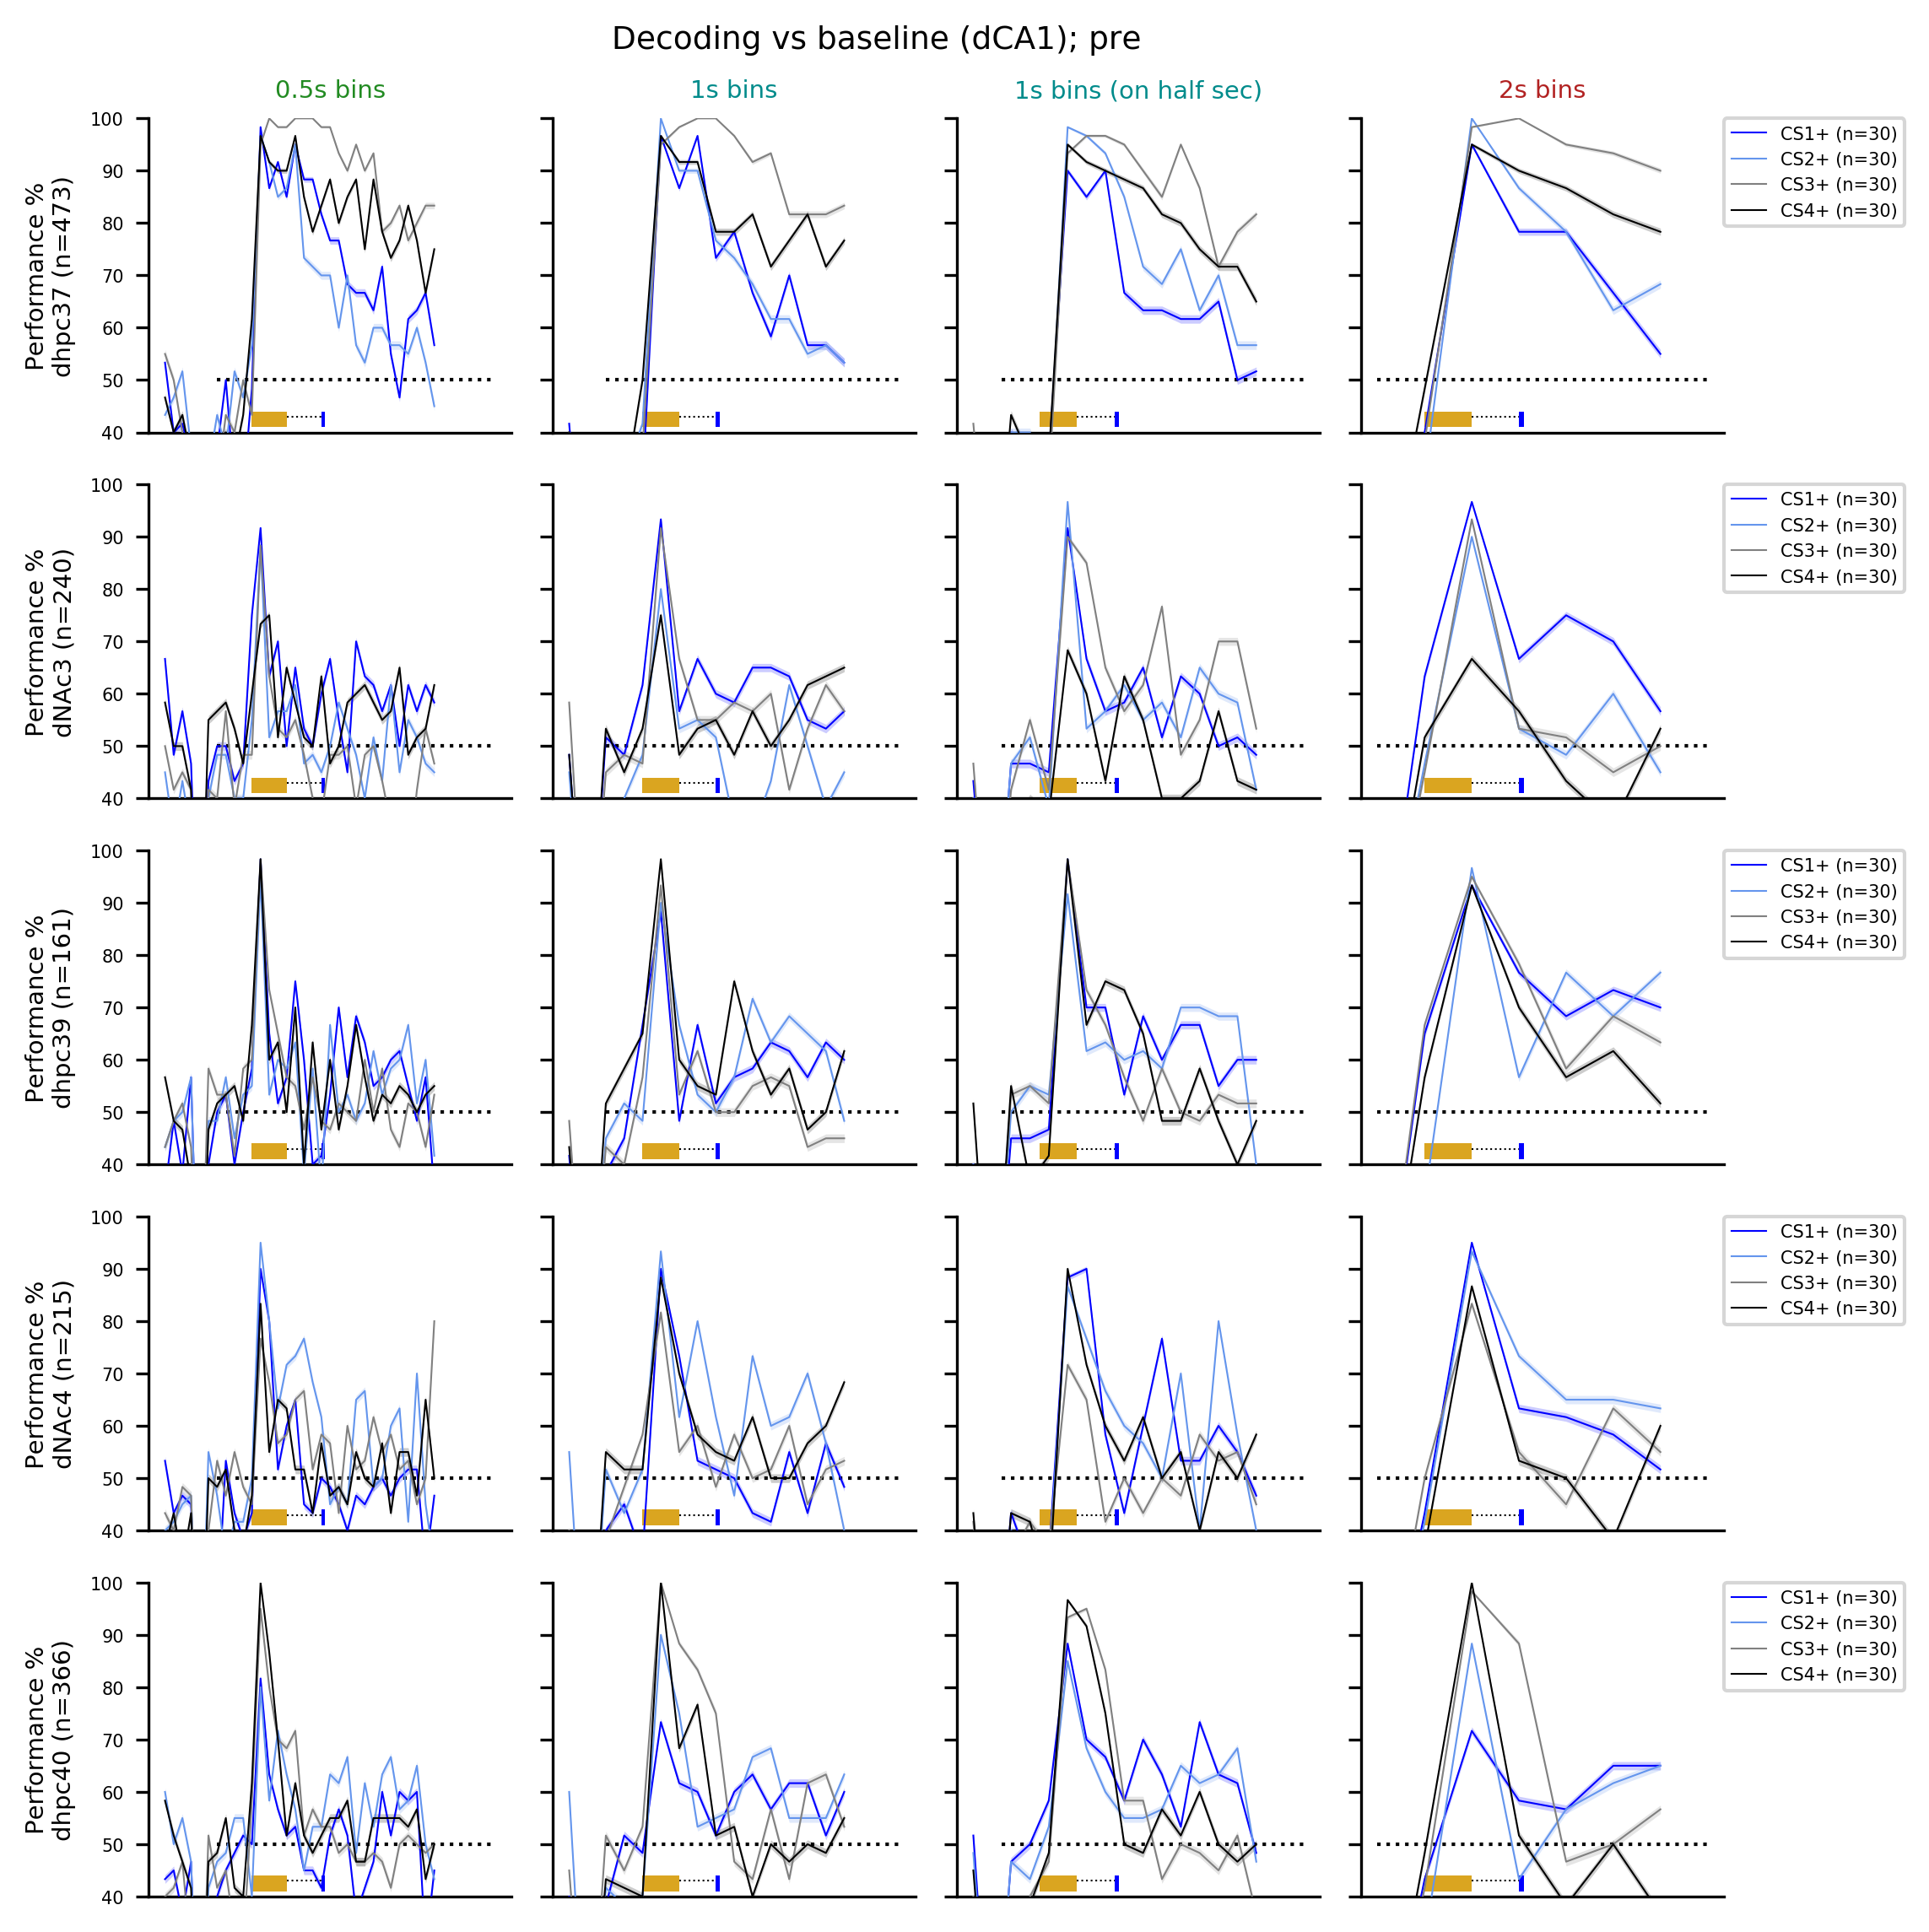

In [51]:
ses = 'pre'
fig, ax = pl.subplots(len(eval("labels_%s.keys()"%ses)),4, figsize=(7, 1.5*len(eval("labels_%s.keys()"%ses))),sharey=True)

for r,tb,sub in zip(range(4),bins,[10,4,3.5,1]):
    for y,key in zip(range(len(eval("labels_%s.keys()"%ses))),eval("labels_%s.keys()"%ses)):
        for comp,c,la in zip(['CS1','CS2','CS3','CS4'],['b','cornflowerblue','grey','k'],
                     ['CS1+ (n='+str(np.sum(eval("labels_%s[key]==1"%ses)))+")",
                      'CS2+ (n='+str(np.sum(eval("labels_%s[key]==2"%ses)))+")",
                      'CS3+ (n='+str(np.sum(eval("labels_%s[key]==3"%ses)))+")",
                      'CS4+ (n='+str(np.sum(eval("labels_%s[key]==4"%ses)))+")"]):
            try:
                ax[y][r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("individ_scores_%s_%s_%s_%s[key]"%(comp,tb,ses,t,)))*100) for t in range(bin_ranges[r])],
                           color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
                m = np.array([(np.mean(eval("individ_scores_%s_%s_%s_%s[key]"%(comp,tb,ses,t)))*100) for t in range(bin_ranges[r])])
                #s = np.array([np.std(eval("individ_scores_%s_%s_%s_%s['c18m9']"%(comp,tb,ses,t,)))*100 for t in range(bin_ranges[r])])
                SEM = np.array([(np.std(eval("individ_scores_%s_%s_%s_%s[key]"%(comp,tb,ses,t)))/(eval("individ_scores_%s_%s_%s_%s[key]"%(comp,tb,ses,t)).shape[1]))*100 for t in range(bin_ranges[r])])
                ax[y][r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-SEM,m+SEM,alpha=0.2,color=c,linewidth=0)
                ax[y][3].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
            except:
                continue
for x,tick in zip(range(4),[2,1,1,.5]):
    for y,key in zip(range(len(eval("labels_%s.keys()"%ses))),eval("labels_%s.keys()"%ses)):
        ax[y][x].set_ylim(40, 100)
        #ax[y][x].set_xlim(-3, bin_ranges[x])
        #ax[y][x].set_xticks(np.arange(-2,11, 1))
        #ax[y][x].set_xticklabels(np.arange(-2,11, .5))
        ax[y][x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
        #ax[y][x].set_xlabel('Time from odor onset (s)')
        ax[y][0].set_ylabel('Performance %\n'+key+" (n="+str(eval("patterns_1s_%s[key].shape[-1]"%ses))+")")
        pt.plot_period_bar(ax[y][x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
        pt.plot_period_bar(ax[y][x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
        ax[y][x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
        ax[y][x].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
ax[0][0].set_title('0.5s bins', color=dark_co[0])
ax[0][1].set_title('1s bins', color = dark_co[1])
ax[0][2].set_title('1s bins (on half sec)', color = dark_co[1])
ax[0][3].set_title('2s bins', color = dark_co[2])
pl.suptitle("Decoding vs baseline (dCA1); %s"%ses, fontsize=9, y=1.01)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_%s_individ.jpg'%(NOTEBOOK_NAME,ses))

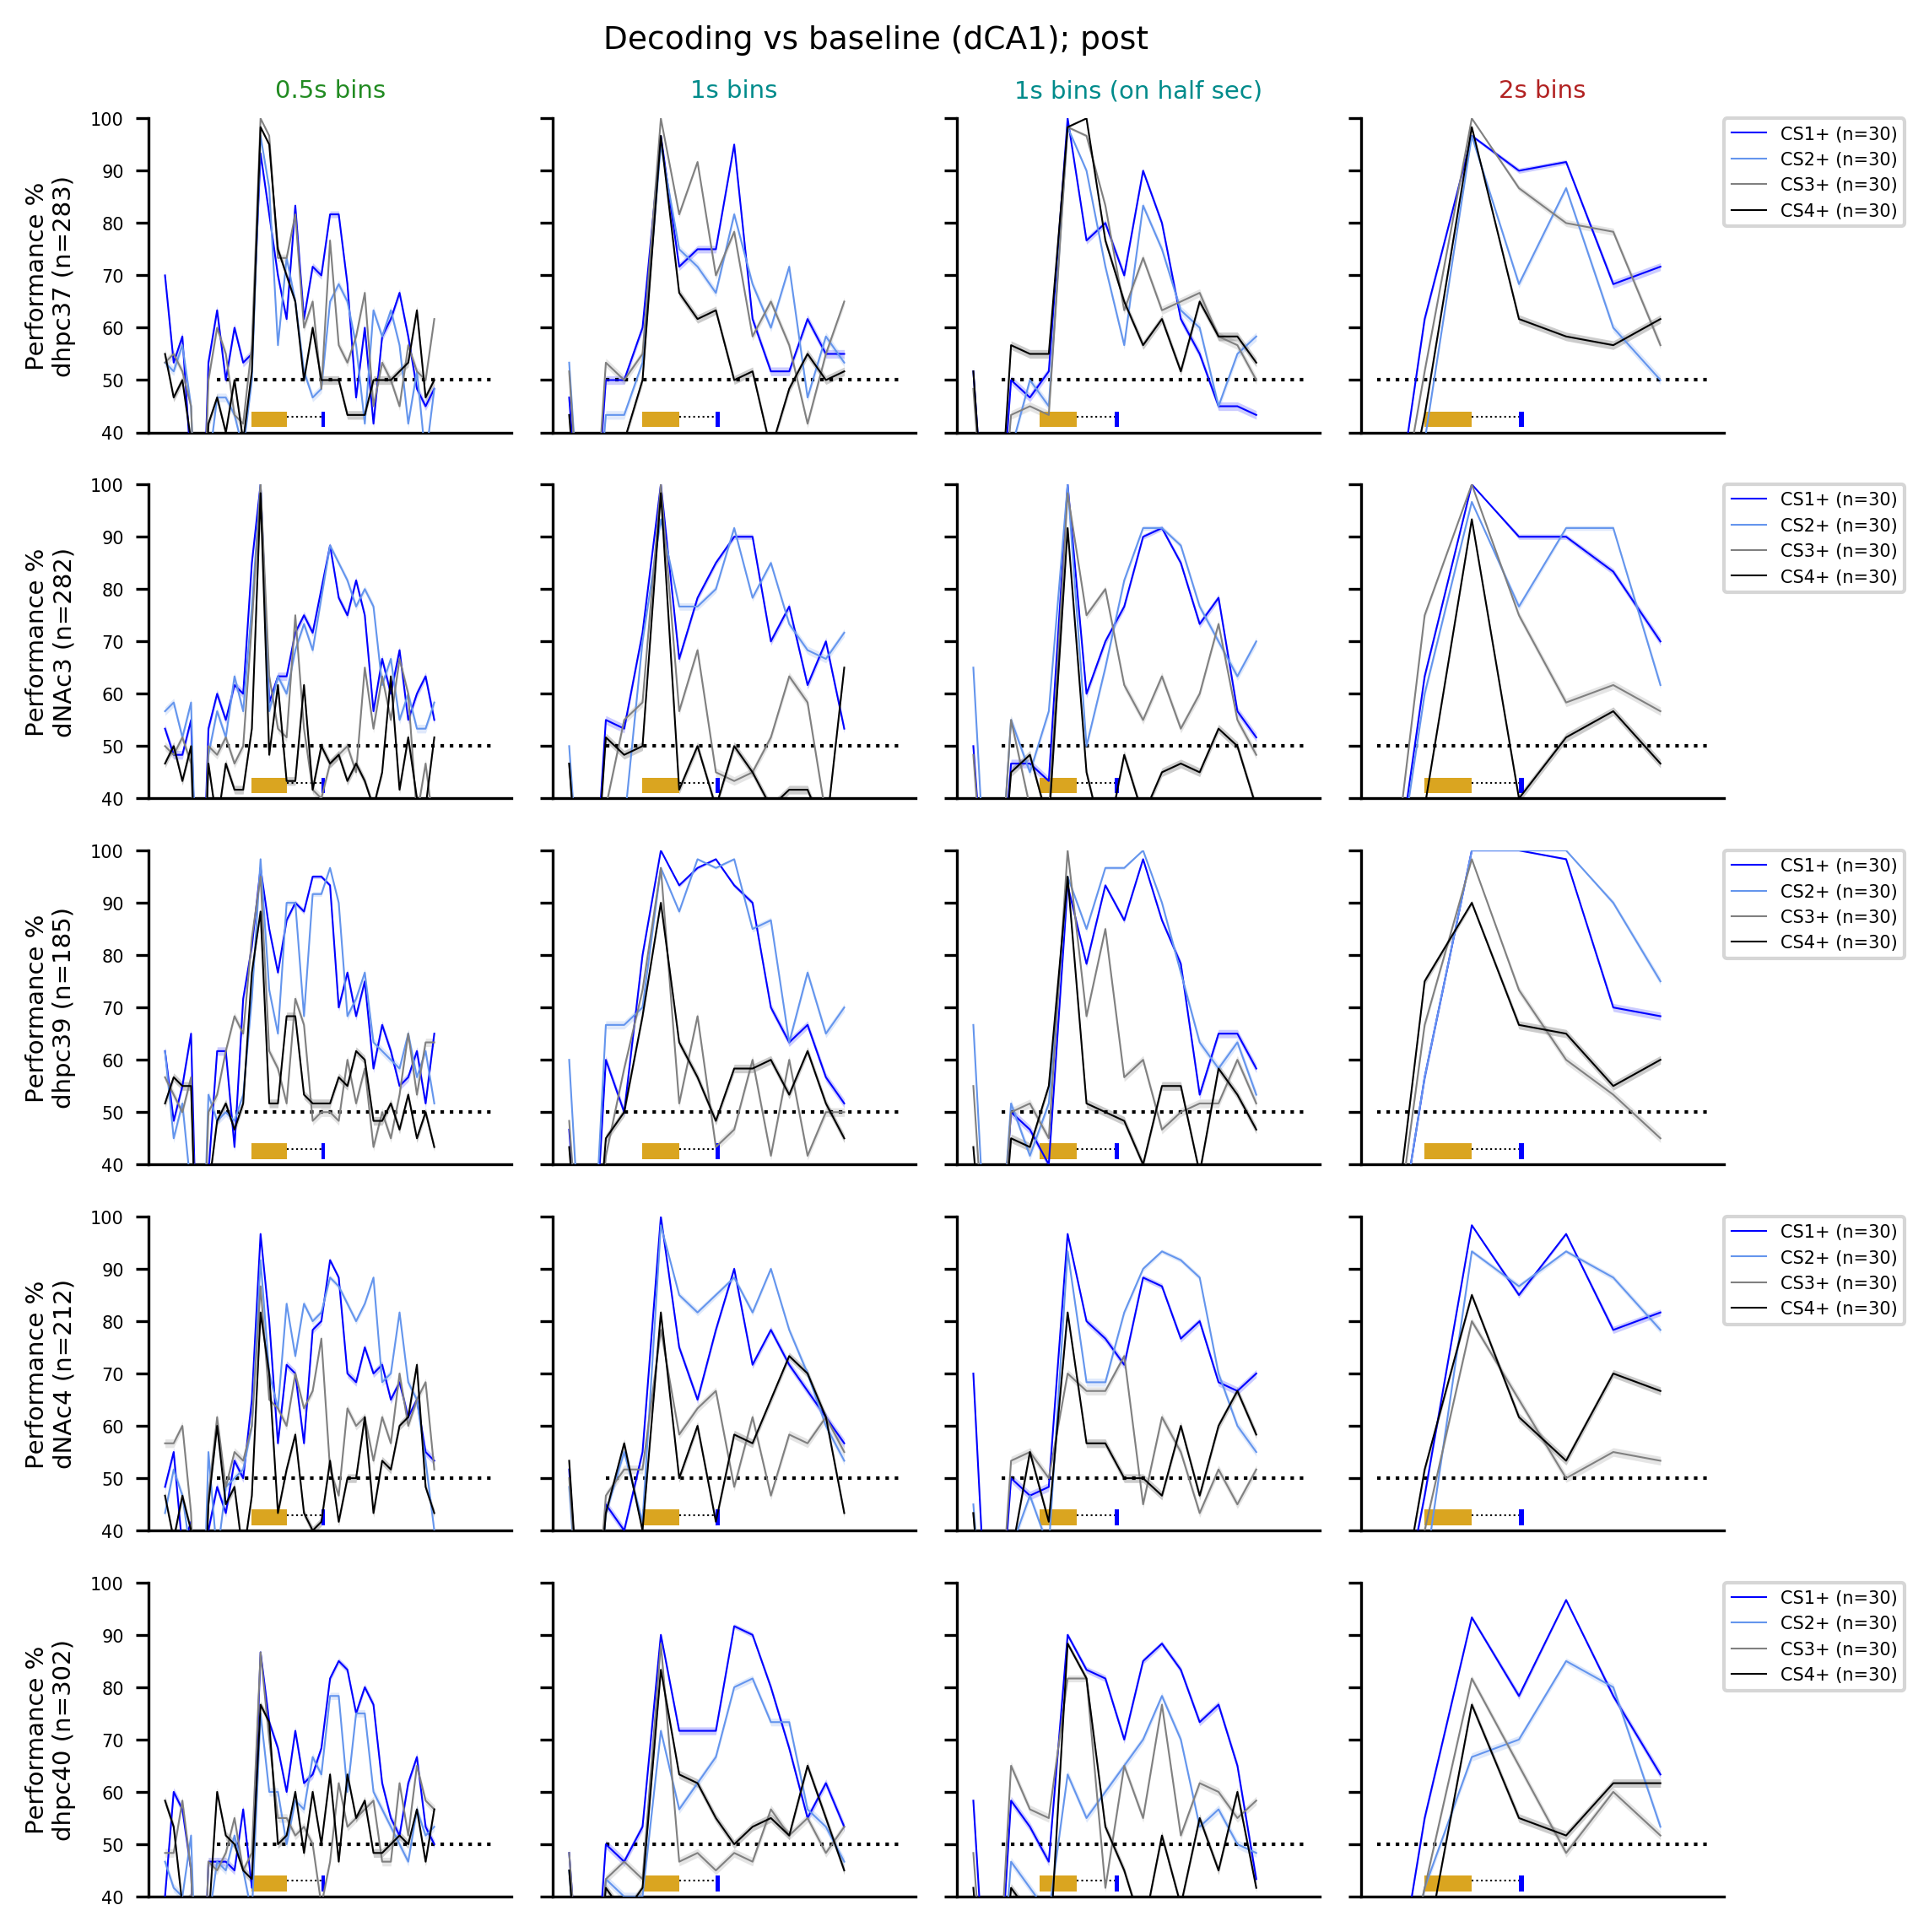

In [52]:
ses = 'post'
fig, ax = pl.subplots(len(eval("labels_%s.keys()"%ses)),4, figsize=(7, 1.5*len(eval("labels_%s.keys()"%ses))),sharey=True)

for r,tb,sub in zip(range(4),bins,[10,4,3.5,1]):
    for y,key in zip(range(len(eval("labels_%s.keys()"%ses))),eval("labels_%s.keys()"%ses)):
        for comp,c,la in zip(['CS1','CS2','CS3','CS4'],['b','cornflowerblue','grey','k'],
                     ['CS1+ (n='+str(np.sum(eval("labels_%s[key]==1"%ses)))+")",
                      'CS2+ (n='+str(np.sum(eval("labels_%s[key]==2"%ses)))+")",
                      'CS3+ (n='+str(np.sum(eval("labels_%s[key]==3"%ses)))+")",
                      'CS4+ (n='+str(np.sum(eval("labels_%s[key]==4"%ses)))+")"]):
            try:
                ax[y][r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("individ_scores_%s_%s_%s_%s[key]"%(comp,tb,ses,t,)))*100) for t in range(bin_ranges[r])],
                           color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
                m = np.array([(np.mean(eval("individ_scores_%s_%s_%s_%s[key]"%(comp,tb,ses,t)))*100) for t in range(bin_ranges[r])])
                #s = np.array([np.std(eval("individ_scores_%s_%s_%s_%s['c18m9']"%(comp,tb,ses,t,)))*100 for t in range(bin_ranges[r])])
                SEM = np.array([(np.std(eval("individ_scores_%s_%s_%s_%s[key]"%(comp,tb,ses,t)))/(eval("individ_scores_%s_%s_%s_%s[key]"%(comp,tb,ses,t)).shape[1]))*100 for t in range(bin_ranges[r])])
                ax[y][r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-SEM,m+SEM,alpha=0.2,color=c,linewidth=0)
                ax[y][3].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
            except:
                continue
for x,tick in zip(range(4),[2,1,1,.5]):
    for y,key in zip(range(len(eval("labels_%s.keys()"%ses))),eval("labels_%s.keys()"%ses)):
        ax[y][x].set_ylim(40, 100)
        #ax[y][x].set_xlim(-3, bin_ranges[x])
        #ax[y][x].set_xticks(np.arange(-2,11, 1))
        #ax[y][x].set_xticklabels(np.arange(-2,11, .5))
        ax[y][x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
        #ax[y][x].set_xlabel('Time from odor onset (s)')
        ax[y][0].set_ylabel('Performance %\n'+key+" (n="+str(eval("patterns_1s_%s[key].shape[-1]"%ses))+")")
        pt.plot_period_bar(ax[y][x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
        pt.plot_period_bar(ax[y][x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
        ax[y][x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
        ax[y][x].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
ax[0][0].set_title('0.5s bins', color=dark_co[0])
ax[0][1].set_title('1s bins', color = dark_co[1])
ax[0][2].set_title('1s bins (on half sec)', color = dark_co[1])
ax[0][3].set_title('2s bins', color = dark_co[2])
pl.suptitle("Decoding vs baseline (dCA1); %s"%ses, fontsize=9, y=1.01)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_%s_individ.jpg'%(NOTEBOOK_NAME,ses))

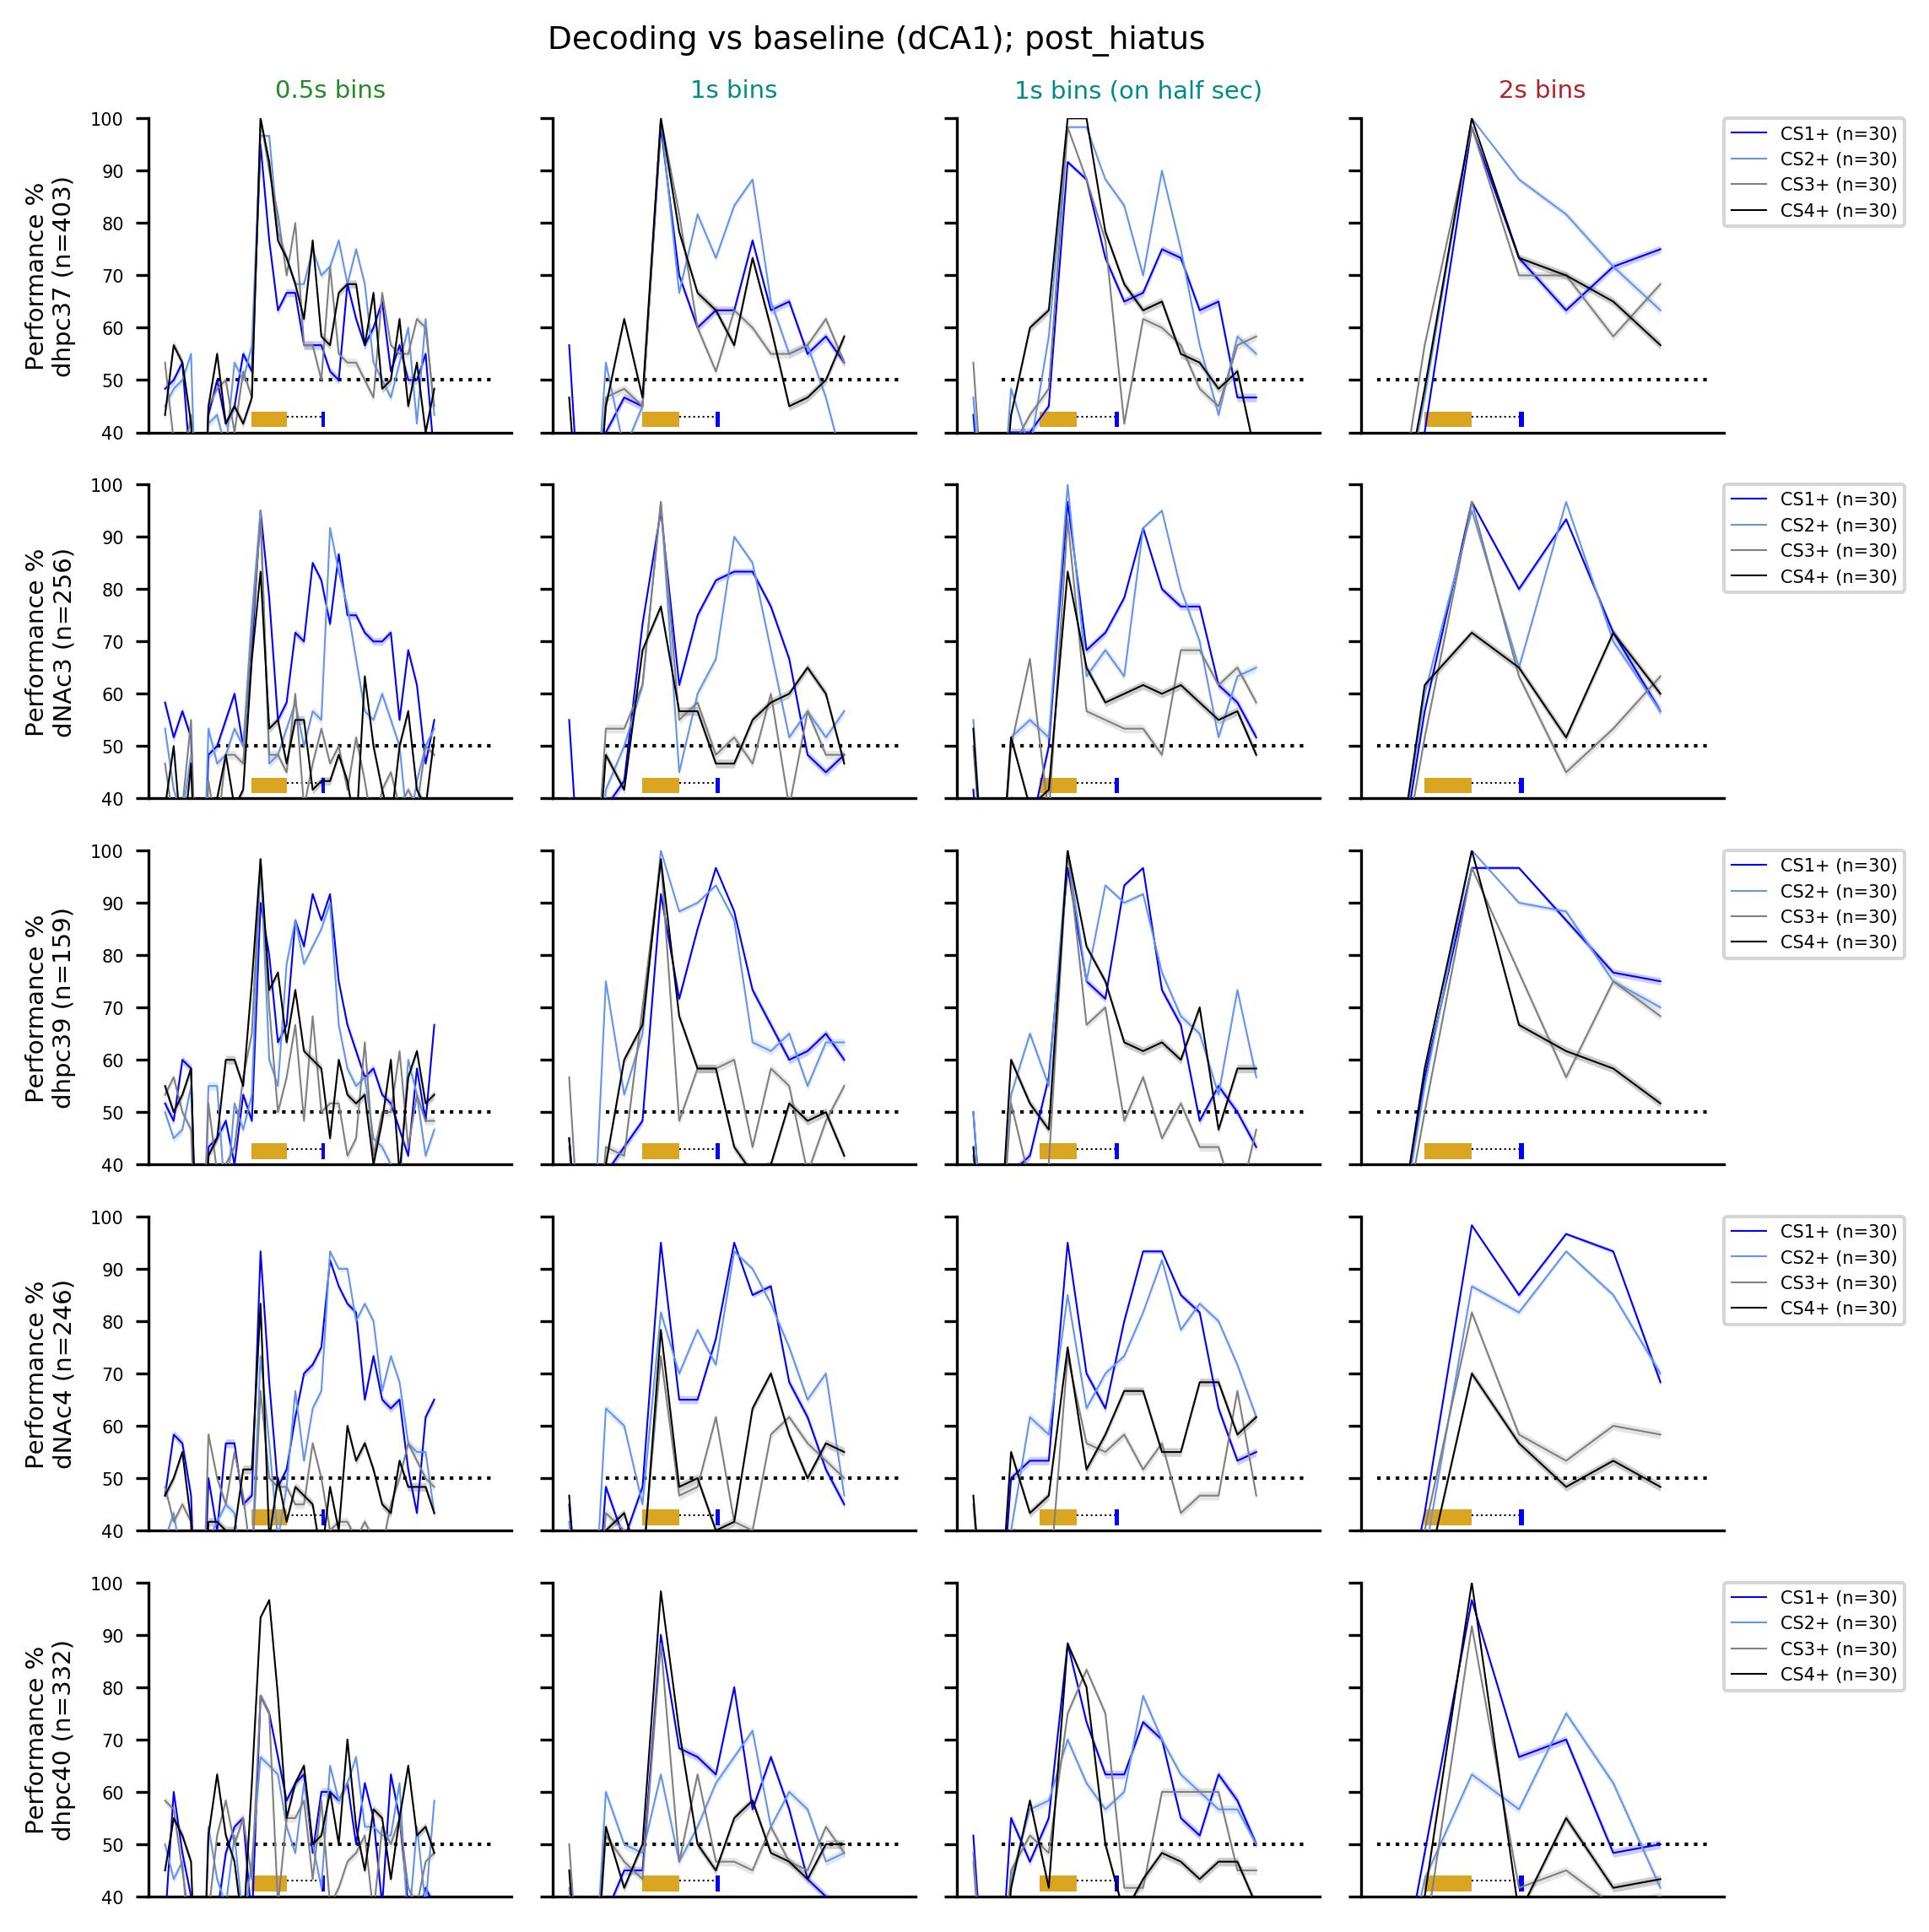

In [53]:
ses = 'post_hiatus'
fig, ax = pl.subplots(len(eval("labels_%s.keys()"%ses)),4, figsize=(7, 1.5*len(eval("labels_%s.keys()"%ses))),sharey=True)

for r,tb,sub in zip(range(4),bins,[10,4,3.5,1]):
    for y,key in zip(range(len(eval("labels_%s.keys()"%ses))),eval("labels_%s.keys()"%ses)):
        for comp,c,la in zip(['CS1','CS2','CS3','CS4'],['b','cornflowerblue','grey','k'],
                     ['CS1+ (n='+str(np.sum(eval("labels_%s[key]==1"%ses)))+")",
                      'CS2+ (n='+str(np.sum(eval("labels_%s[key]==2"%ses)))+")",
                      'CS3+ (n='+str(np.sum(eval("labels_%s[key]==3"%ses)))+")",
                      'CS4+ (n='+str(np.sum(eval("labels_%s[key]==4"%ses)))+")"]):
            try:
                ax[y][r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("individ_scores_%s_%s_%s_%s[key]"%(comp,tb,ses,t,)))*100) for t in range(bin_ranges[r])],
                           color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
                m = np.array([(np.mean(eval("individ_scores_%s_%s_%s_%s[key]"%(comp,tb,ses,t)))*100) for t in range(bin_ranges[r])])
                #s = np.array([np.std(eval("individ_scores_%s_%s_%s_%s['c18m9']"%(comp,tb,ses,t,)))*100 for t in range(bin_ranges[r])])
                SEM = np.array([(np.std(eval("individ_scores_%s_%s_%s_%s[key]"%(comp,tb,ses,t)))/(eval("individ_scores_%s_%s_%s_%s[key]"%(comp,tb,ses,t)).shape[1]))*100 for t in range(bin_ranges[r])])
                ax[y][r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-SEM,m+SEM,alpha=0.2,color=c,linewidth=0)
                ax[y][3].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
            except:
                continue
for x,tick in zip(range(4),[2,1,1,.5]):
    for y,key in zip(range(len(eval("labels_%s.keys()"%ses))),eval("labels_%s.keys()"%ses)):
        ax[y][x].set_ylim(40, 100)
        #ax[y][x].set_xlim(-3, bin_ranges[x])
        #ax[y][x].set_xticks(np.arange(-2,11, 1))
        #ax[y][x].set_xticklabels(np.arange(-2,11, .5))
        ax[y][x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
        #ax[y][x].set_xlabel('Time from odor onset (s)')
        ax[y][0].set_ylabel('Performance %\n'+key+" (n="+str(eval("patterns_1s_%s[key].shape[-1]"%ses))+")")
        pt.plot_period_bar(ax[y][x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
        pt.plot_period_bar(ax[y][x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
        ax[y][x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
        ax[y][x].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
ax[0][0].set_title('0.5s bins', color=dark_co[0])
ax[0][1].set_title('1s bins', color = dark_co[1])
ax[0][2].set_title('1s bins (on half sec)', color = dark_co[1])
ax[0][3].set_title('2s bins', color = dark_co[2])
pl.suptitle("Decoding vs baseline (dCA1); %s"%ses, fontsize=9, y=1.01)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_%s_individ.jpg'%(NOTEBOOK_NAME,ses))

# Now for equalizing cell #s across all sess by using min

In [59]:
%%time
#get train and test subsamples for each timebin, for each session

n_loops=30
classes = [1,10],[2,20],[3,30],[4,40]
comparison_labels='CS1','CS2','CS3','CS4'
for tb,i in zip(bins,range(len(bins))):
    for t in range(bin_ranges[i]): # number of time bins
        for cl,comp_la in zip(classes,comparison_labels):
            exec('baseline_scores_gmin_%s_%s_%s = {}'%(tb,t,comp_la))
            for sess in sessions:
                print sess,t,comp_la,
                try:
                    eval("baseline_scores_gmin_%s_%s_%s"%(tb,t,comp_la))[sess] = np.r_[[do_test_within(eval("patterns_%s_%s_%s_w_baselines"%(tb,sess,t)),
                        eval("labels_%s_w_baselines"%sess),classes=cl, n_cells=315, relabel=None) for i in range(n_loops)]]
                except:
                    print 'NOPE',

expo 0 CS1 pre 0 CS1 post 0 CS1 post_hiatus 0 CS1 expo 0 CS2 pre 0 CS2 post 0 CS2 post_hiatus 0 CS2 expo 0 CS3 pre 0 CS3 post 0 CS3 post_hiatus 0 CS3 expo 0 CS4 pre 0 CS4 post 0 CS4 post_hiatus 0 CS4 expo 1 CS1 pre 1 CS1 post 1 CS1 post_hiatus 1 CS1 expo 1 CS2 pre 1 CS2 post 1 CS2 post_hiatus 1 CS2 expo 1 CS3 pre 1 CS3 post 1 CS3 post_hiatus 1 CS3 expo 1 CS4 pre 1 CS4 post 1 CS4 post_hiatus 1 CS4 expo 2 CS1 pre 2 CS1 post 2 CS1 post_hiatus 2 CS1 expo 2 CS2 pre 2 CS2 post 2 CS2 post_hiatus 2 CS2 expo 2 CS3 pre 2 CS3 post 2 CS3 post_hiatus 2 CS3 expo 2 CS4 pre 2 CS4 post 2 CS4 post_hiatus 2 CS4 expo 3 CS1 pre 3 CS1 post 3 CS1 post_hiatus 3 CS1 expo 3 CS2 pre 3 CS2 post 3 CS2 post_hiatus 3 CS2 expo 3 CS3 pre 3 CS3 post 3 CS3 post_hiatus 3 CS3 expo 3 CS4 pre 3 CS4 post 3 CS4 post_hiatus 3 CS4 expo 4 CS1 pre 4 CS1 post 4 CS1 post_hiatus 4 CS1 expo 4 CS2 pre 4 CS2 post 4 CS2 post_hiatus 4 CS2 expo 4 CS3 pre 4 CS3 post 4 CS3 post_hiatus 4 CS3 expo 4 CS4 pre 4 CS4 post 4 CS4 post_hiatus 4 CS4 

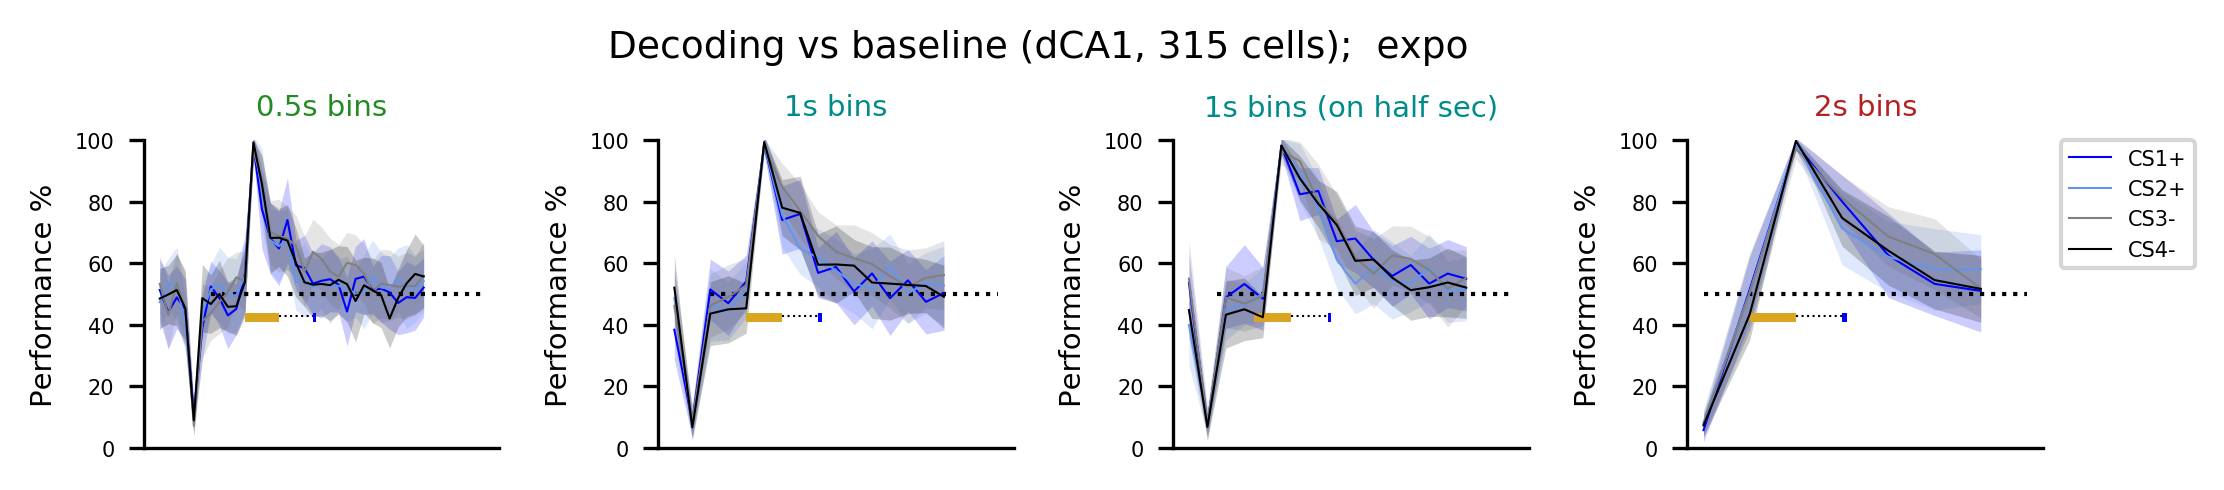

In [60]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))
session='expo'
for comp,c,la in zip(['CS1','CS2','CS3','CS4'],['b','cornflowerblue','grey','k'],['CS1+','CS2+','CS3-','CS4-']):
    for r,tb,sub in zip(range(4),bins,[10,4,3.5,1]):
        try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("baseline_scores_gmin_%s_%s_%s[session]"%(tb,t,comp)))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_gmin_%s_%s_%s[session]"%(tb,t,comp)))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("baseline_scores_gmin_%s_%s_%s[session]"%(tb,t,comp)))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        except:
            continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins', color=dark_co[0])
ax[1].set_title('1s bins', color = dark_co[1])
ax[2].set_title('1s bins (on half sec)', color = dark_co[1])
ax[3].set_title('2s bins', color = dark_co[2])
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (dCA1, 315 cells);  %s"%session, fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_%s_gmin.jpg'%(NOTEBOOK_NAME,session))

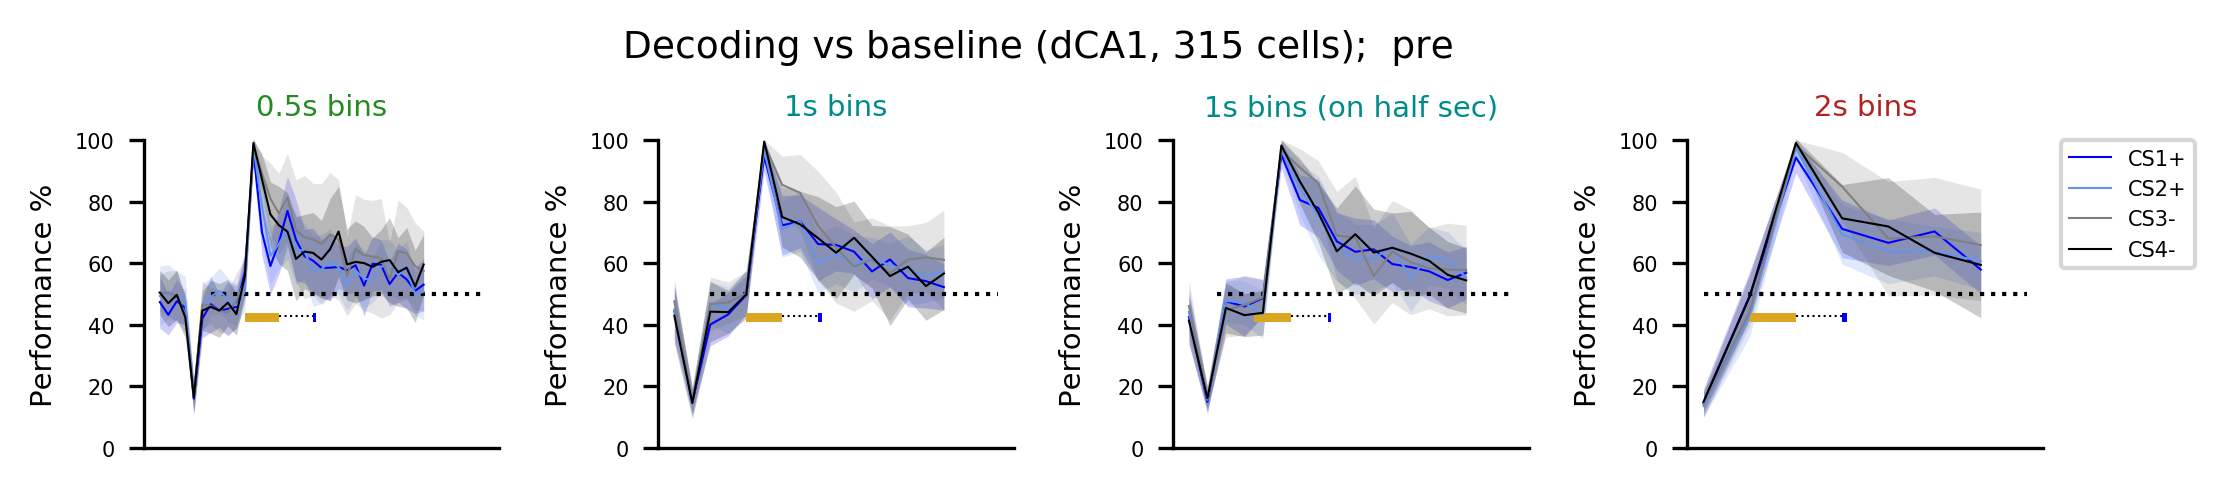

In [61]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))
session='pre'
for comp,c,la in zip(['CS1','CS2','CS3','CS4'],['b','cornflowerblue','grey','k'],['CS1+','CS2+','CS3-','CS4-']):
    for r,tb,sub in zip(range(4),bins,[10,4,3.5,1]):
        try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("baseline_scores_gmin_%s_%s_%s[session]"%(tb,t,comp)))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_gmin_%s_%s_%s[session]"%(tb,t,comp)))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("baseline_scores_gmin_%s_%s_%s[session]"%(tb,t,comp)))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        except:
            continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins', color=dark_co[0])
ax[1].set_title('1s bins', color = dark_co[1])
ax[2].set_title('1s bins (on half sec)', color = dark_co[1])
ax[3].set_title('2s bins', color = dark_co[2])
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (dCA1, 315 cells);  %s"%session, fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_%s_gmin.jpg'%(NOTEBOOK_NAME,session))

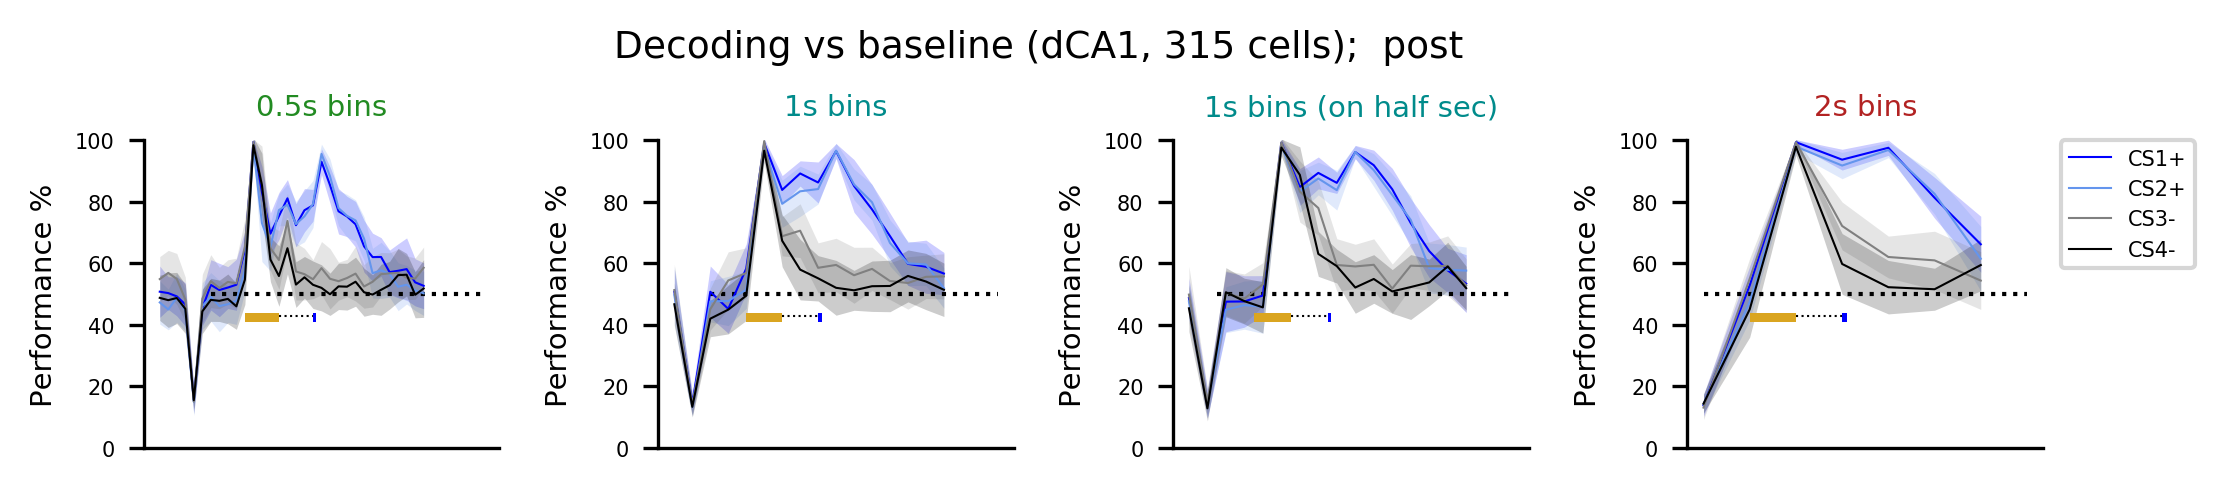

In [62]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))
session='post'
for comp,c,la in zip(['CS1','CS2','CS3','CS4'],['b','cornflowerblue','grey','k'],['CS1+','CS2+','CS3-','CS4-']):
    for r,tb,sub in zip(range(4),bins,[10,4,3.5,1]):
        try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("baseline_scores_gmin_%s_%s_%s[session]"%(tb,t,comp)))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_gmin_%s_%s_%s[session]"%(tb,t,comp)))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("baseline_scores_gmin_%s_%s_%s[session]"%(tb,t,comp)))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        except:
            continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins', color=dark_co[0])
ax[1].set_title('1s bins', color = dark_co[1])
ax[2].set_title('1s bins (on half sec)', color = dark_co[1])
ax[3].set_title('2s bins', color = dark_co[2])
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (dCA1, 315 cells);  %s"%session, fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_%s_gmin.jpg'%(NOTEBOOK_NAME,session))

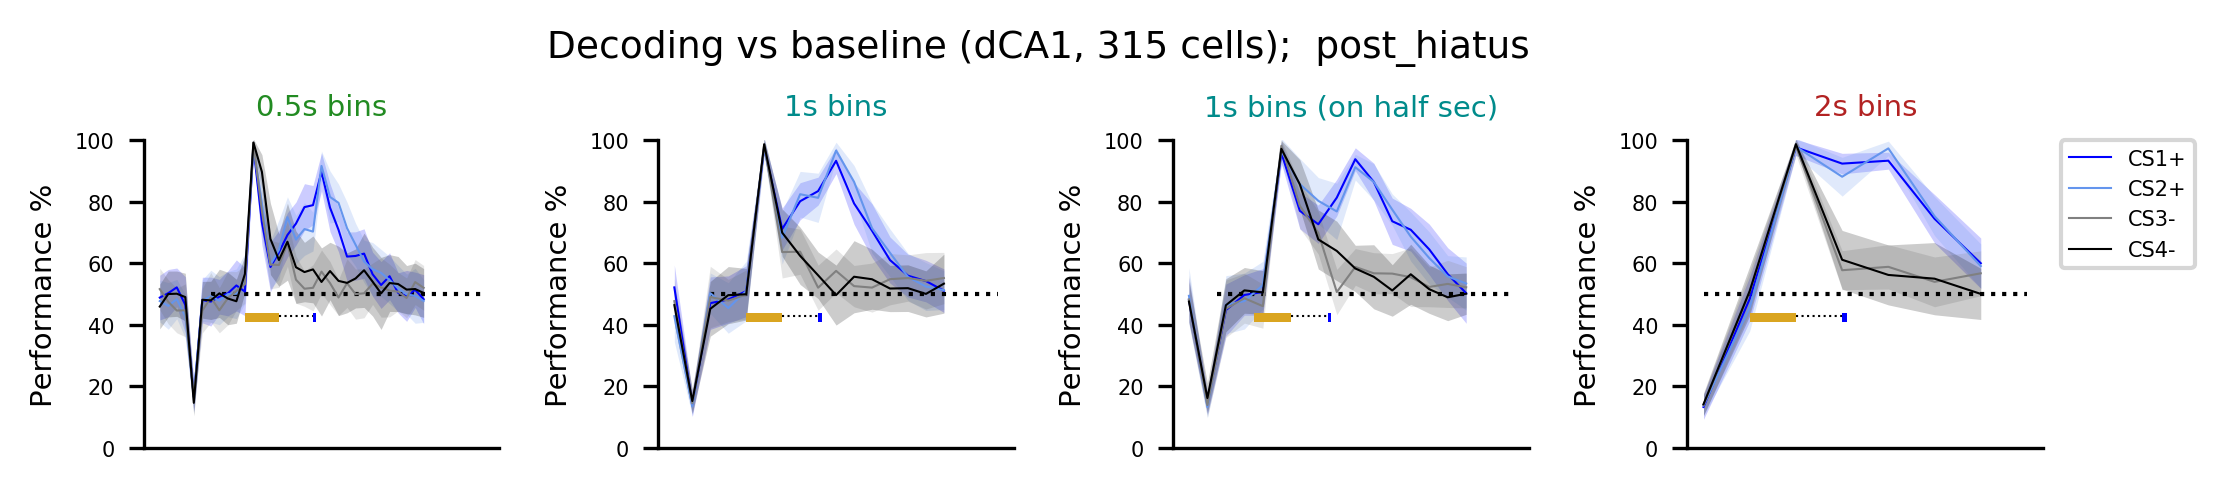

In [63]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))
session='post_hiatus'
for comp,c,la in zip(['CS1','CS2','CS3','CS4'],['b','cornflowerblue','grey','k'],['CS1+','CS2+','CS3-','CS4-']):
    for r,tb,sub in zip(range(4),bins,[10,4,3.5,1]):
        try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("baseline_scores_gmin_%s_%s_%s[session]"%(tb,t,comp)))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_gmin_%s_%s_%s[session]"%(tb,t,comp)))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("baseline_scores_gmin_%s_%s_%s[session]"%(tb,t,comp)))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        except:
            continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins', color=dark_co[0])
ax[1].set_title('1s bins', color = dark_co[1])
ax[2].set_title('1s bins (on half sec)', color = dark_co[1])
ax[3].set_title('2s bins', color = dark_co[2])
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (dCA1, 315 cells);  %s"%session, fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_%s_gmin.jpg'%(NOTEBOOK_NAME,session))

In [1]:
save_workspace(db)

NameError: name 'save_workspace' is not defined